
## **Chatbot Assessment**


## **Chatbot Setup and Preparations**
------------
~~~~~~
To start, Download the data ZIP file
`here <https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html>`__
and put in a ``data/`` directory under the current directory.

After that, let’s import some necessities.


Import necessary libraries and setup the GPU as the hardware accelerator for the notebook

In [24]:
from __future__ import absolute_import # Import resources using the full file path from the projects root directory
from __future__ import division # Update and change the division operator to true division (floating point numbers as output regardless)
from __future__ import print_function # Enable stringigised output for debugging purposes
from __future__ import unicode_literals # Enable string literals to be converted into unicode literals (text into number sequences)

import torch # Import the Torch library, used for tensor computation and machine learning (neural networks) support
from torch.jit import script, trace # Import TorchScript (JIT - just-in-time compilation) function scripting (compile methods and functions as TorchScript code) and tracing (return executable(s) that is optimised using JIT) support
import torch.nn as nn # Import neural network creation and training support
from torch import optim # Import optimization algorithm support, for the use of adjusting parameters affecting neural network learning processes 
import torch.nn.functional as F # Import one-dimensional convolution support for input composed of multiple input planes, in neural networks (output tensor)
import csv # Import comma seperated value file support, for importing and exporting date to and from spreadsheets and databases
import random # Import randomization support
import re # Import regular expression support for the purpose of matching character sequences with other character sequences (strings and sets of strings)
import os # Import operating system dependant functionality use support
import unicodedata # Import unicode database support for quering unicode literals by name (string format)
import codecs # Import stream and file interface support, for transcoding program data (unicode encoding)
from io import open # Import file input and output streaming support, for opening files external to the program
import itertools # Import iterative functionality support
import math # Import mathematical functionality support

#import sys # Import python runtime environment manipulation functionality
#!{sys.executable} -m pip install pyspellchecker # Install the python spell checker library (based upon Peter Norvig's spell checker implementation - manual implementation is shown in the vocabulary class)
#from spellchecker import spellchecker # Import the spell checking and correction functionality

from random import seed # Import random number generation intialisation support
from random import randint # Import random integer generation support

import time # Import time-related functionality support

from pathlib import Path # Import filesystem functionality support

# Produce plots that are inline with the notebooks cell indentation, beneath the code cell producing commanding the plot output, store the plot in the notebook
%matplotlib inline

import matplotlib.pyplot as plt # Import figure plotting support (similarities to MATLAB)
import matplotlib.ticker as ticker # Import figure plotting axes ticking support
import numpy as np # Import general-purpose array-processing support
import plotly.graph_objects as go # Import graph object functionality support

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # Import BLEU (Bilingual Evaluation Understudy) score calculation and score smoothing support
from difflib import SequenceMatcher # Import sequence comparison functionality support
!pip install pip install python-Levenshtein # Install Levenshtein (edit) distance and edit operations, string similarity, approximate median strings and averaging, string sequencing and set similarity support
import Levenshtein # Import Levenshtein (edit) distance and edit operations, string similarity, approximate median strings and averaging, string sequencing and set similarity support

import nltk # Import natural language toolkit (NLTK) support (natural language processing (NLP))
nltk.download('punkt') # Download the punkt sequence tokenizer package (tokenizing support)
nltk.download('stopwords') # Download the sentence stop words package 
from nltk.corpus import stopwords # Import stop word filter and processing support
from nltk.tokenize import word_tokenize # Import substring and string tokenizing support (words and punctuation to numerical tokens)

CUDA_IS_AVAILABLE = torch.cuda.is_available() # Determine whether a GPU is present for the operating device
device = torch.device("cuda" if CUDA_IS_AVAILABLE else "cpu") # Determine the hardware accelerator(s) in use (Compute Unified Device Architecture - use GPU and CPU in parallel to perform calculations)
print("Hardware accelerator in use: {}".format(device)) # Output the hardware accelerator used to execute the notebook

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Hardware accelerator in use: cuda


## **Load and Preprocess Data**
----------------------
~~~~~~
The next step is to reformat our data file and load the data into
structures that we can work with.


The Cornell movie-dialogs corpus
Corpus <https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html>`
is a rich dataset of movie character dialog:

-  220,579 conversational exchanges between 10,292 pairs of movie
   characters
-  9,035 characters from 617 movies
-  304,713 total utterances

This dataset is large and diverse, and there is a great variation of
language formality, time periods, sentiment, etc. Our hope is that this
diversity makes our model robust to many forms of inputs and queries.


The Cornell movie-quotes corpus
Corpus <https://www.cs.cornell.edu/~cristian/memorability.html>
is a collection of movie lines together with memorability annotations:

- 894014 movie script lines
- from 1068 movie scripts
- 6282 one-line memorable quotes that are automatically matched with the script line which contain them
- 2197 one-sentence memorable quotes paired with surrounding non-memorable quotes from the same movie, spoken by the same character and containing the same number of words


The WikiQA corpus
Corpus <https://www.microsoft.com/en-us/download/details.aspx?id=52419&from=http%3A%2F%2Fresearch.microsoft.com%2Fapps%2Fmobile%2Fdownload.aspx%3Fp%3D4495da01-db8c-4041-a7f6-7984a4f6a905>
is a new publicly available set of question and sentence pairs, collected and annotated for research on open-domain question answering. With the help of crowdsourcing, it includes:

- 3,047 questions
- 29,258 sentences in the dataset
- 1,473 sentences were labeled as answer sentences to their corresponding questions.


First, we’ll take a look at some lines of our data file to see the
original format.


Link Google Drive with the notebook

In [25]:
from google.colab import drive # Import Google Drive support
drive.mount('/content/drive', force_remount = False) # Mount the Google Drive associated with the account operating the notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Access the chosen text corpus from the Google Drive directory configured

In [26]:
# Corpora available: cornell movie-dialogs corpus (CMD), cornell movie-quotes corpus (CMQ), the WikiQA corpus (WIKI)
corpus_name = {"CMD": "cornell movie-dialogs corpus/movie_lines.txt/movie_conversations.txt", 
               "CMQ": "cornell movie-quotes corpus/moviequotes_scripts.txt",
               "WIKI": "WikiQA corpus/WikiQA_train.txt"} # Initialise a dictionary representing the keyed series of nominated text corpus (language resources)

corpus_choice = "CMQ" # Initialise the text corpus to be used to train the chatbot model

directory_extensions = corpus_name[corpus_choice].split('/') # Split the dictionairy entries by their extensions to the folder in the Google Drive directory mounted

corpus_data_directory = "/content/drive/My Drive/Colab Notebooks/Data" # Define the absolute directory of the corpus
corpus = os.path.join(corpus_data_directory, directory_extensions[0]) # Configure and combine the absolute directory of the corpus and its folders name

print(directory_extensions, '\n') # Output the directory and extensions for the text corpus chosen (check setup correctly)



# Function declaration, print the first '10' lines of a parsed text file
def printLines(file, number_of_lines = 10):
    number_of_lines_file = 0 # Initialise the number of lines of text read in the file

    with open(file, 'rb') as data_file: # Open the file parsed
        lines = data_file.readlines() # Read and parse the file as lines
    
    for line in lines[:number_of_lines]: # For each line in the line array, do the following
        print(line) # Output each line of text read-in, per line

    for line in lines: # For each line in the line array, do the following
        number_of_lines_file += 1 # Increment the number of lines of text read in the file
      
    print("\nNumber of lines in the file:", number_of_lines_file) # Output the number of lines parsed in the file

    return number_of_lines_file # Return the number of lines of text read in the file being parsed

# Text files available: movie_lines.txt (CMD), moviequotes_scripts.txt (CMQ), WikiQA_train.txt (WIKI) 
number_of_lines_file = printLines(os.path.join(corpus, ''.join(directory_extensions[1]))) # Function call, output the lines of text for the file parsed 

['cornell movie-quotes corpus', 'moviequotes_scripts.txt'] 

b'0 +++$+++ "murderland" +++$+++ 1 +++$+++ announcer +++$+++  +++$+++ Ladies and gentlemen, the official mascot of Murderland.... Scraps the Dog !\n'
b'1 +++$+++ "murderland" +++$+++ 2 +++$+++ announcer +++$+++  +++$+++ Choose the doorway that starts you on your magical journey into  MURDERLAND !\n'
b'2 +++$+++ "murderland" +++$+++ 3 +++$+++ johnny +++$+++  +++$+++ I didn\'t think he\'d make it past Scraps.\n'
b'3 +++$+++ "murderland" +++$+++ 4 +++$+++ bruce +++$+++ 2 +++$+++ Let\'s just see if he can make it into round two....\n'
b'4 +++$+++ "murderland" +++$+++ 5 +++$+++ bruce +++$+++  +++$+++ Don\'t.\n'
b'5 +++$+++ "murderland" +++$+++ 6 +++$+++ johnny +++$+++ 4 +++$+++ What ?\n'
b'6 +++$+++ "murderland" +++$+++ 7 +++$+++ bruce +++$+++ 5 +++$+++ Don\'t eat at the console.\n'
b'7 +++$+++ "murderland" +++$+++ 8 +++$+++ johnny +++$+++ 6 +++$+++ What ? Are you my mother ?\n'
b'8 +++$+++ "murderland" +++$+++ 9 +++$+++ bruce +++

## **Create Formatted Data File**
---------
~~~~~~~~~~~~~~~~~~~~~~~~~~

For convenience, we'll create a nicely formatted data file in which each line
contains a tab-separated *query sentence* and a *response sentence* pair.

The following functions facilitate the parsing of the raw
*movie_lines.txt* data file.

-  ``loadLines`` splits each line of the file into a dictionary of
   fields (lineID, characterID, movieID, character, text)
-  ``loadConversations`` groups fields of lines from ``loadLines`` into
   conversations based on *movie_conversations.txt*
-  ``extractSentencePairs`` extracts pairs of sentences from
   conversations


Create a formatted data file for the purpose of seperating lines of text and for identifying the fields that make up said lines

In [27]:
# Function declaration, split each line of the file parsed into a dictionary of fields
def loadLines(file_name, fields):
    lines = {} # Initialise the lines dictionary
    
    with open(file_name, 'r', encoding = 'iso-8859-1') as file: # Open the file being parsed with Latin alphabet encoding
        for line in file: # For each line in the file parsed, do the following
            
            if corpus_choice == "CMD" or corpus_choice == "CMQ": # If the corpus chosen is the cornell movie-dialogs or movie-quotes datasets, do the following
                field_values = line.split(" +++$+++ ") # Split the currently iterated line into a list, for the delimiter passed
            
                line_object = {} # Initialise the line object dictionary, for extracting fields

                for i, field in enumerate(fields): # For the number of fields determined, do the following
                    line_object[field] = field_values[i] # Store the currentlty iterated element from the line (list) at the currently iterated field (map the string to its field)

                lines[line_object["lineID"]] = line_object # Store the current instance of the line object dictionary (all fields), from the first index of the line dictionary onwards

            elif corpus_choice == "WIKI": # If the corpus chosen is the wikiqa dataset, do the following
                field_values = re.split('\t', line) # Split the currently iterated line into a list, for the delimiter passed
                
                line_object = {} # Initialise the line object dictionary, for extracting fields

                for i, field in enumerate(fields): # For the number of fields determined, do the following
                    line_object[field] = field_values[i] # Store the currentlty iterated element from the line (list) at the currently iterated field (map the string to its field)

                    lines[line_object[field]] = line_object # Store the current instance of the line object dictionary (all fields), from the first index of the line dictionary onwards

    return lines # Return the array of lines populated 



# Function declaration, group the fields of lines parsed in the 'loadLines' function into conversations based upon the lines they reside in, according to the 'movie_conversations.txt' text file
def loadConversations(file_name, lines, fields, corpus_choice):
    conversations = [] # Intialise the coversations array
    
    with open(file_name, 'r', encoding = 'iso-8859-1') as file: # Open the file being parsed with Latin alphabet encoding
        for line in file: # For each line in the file parsed, do the following
    
            if corpus_choice == "CMD" or corpus_choice == "CMQ": # If the corpus chosen is the cornell movie-dialogs or movie-quotes datasets, do the following
                field_values = line.split(" +++$+++ ") # Split the currently iterated line into a list, for the delimiter passed
            
            elif corpus_choice == "WIKI": # If the corpus chosen is the wikiqa dataset, do the following
                field_values = re.split('\t', line) # Split the currently iterated line into a list, for the delimiter passed
            
            conversation_object = {} # Initialise the conversation object dictionary, for extracting fields
            
            # Reassemble the lines
            conversation_object["lines"] = [] # Intialise a new field for the conversation object dictionary
            
            for i, field in enumerate(fields): # For the number of fields determined, do the following
                conversation_object[field] = field_values[i] # Store the currentlty iterated element from the line (list) at the currently iterated field (map the string to its field)
            
            if corpus_choice == "CMD": # If the corpus chosen is the cornell movie-dialogs dataset, do the following
                # Convert the string of line numbers into a list of line numbers (conversation_object["utteranceIDs"] == "['L598485', 'L598486', ...]")
                utterance_id_pattern = re.compile('L[0-9]+') # Compile a regular expression pattern into a regular expression pattern object for ordering lines by their number (line id); query and response (ordered)
                lineIds = utterance_id_pattern.findall(conversation_object["utteranceIDs"]) # Store the line numbers of where the line of text parsed exists in the file    
               
                for lineId in lineIds: # For each line ID discovered, do the following
                    conversation_object["lines"].append(lines[lineId]) # Append the information populated for the line number of the line array to the current instance of the conversation object dictionary

                conversations.append(conversation_object) # Append the current instance of coversation object dictionary (all fields) as a new entry to the conversations array 

                #print(conversation_object) # Output the contents of the each conversation object instance

            elif corpus_choice == "CMQ": # If the corpus chosen is the cornell movie-quotes dataset, do the following
                lineID = conversation_object["lineID"] # Store the line number of the current line being parsed in the text
                responseLineID = conversation_object["responseLineID"] # Store the line number corresponding to the current lines predecessor line (the query before the current response) in the conversation
                
                if responseLineID is not '': # If the current lines predecessor line forms a conversation with the current line, do the following
                    conversation = [lines[responseLineID], lines[lineID]] # Store the information for each of the lines in an array, ordered: query, response

                    for i in range(0, 2, 1): # For the range given (start, stop, step), do the following
                        conversation_object["lines"].append(conversation[i]) # Append the information returned for each line to the same array in the 'lines' field (where it can be paired using i and i + 1) as a query and response pair 

                conversations.append(conversation_object) # Append the current instance of coversation object dictionary (all fields) as a new entry to the conversations array 
                    
                #print(conversation_object) # Output the contents of the each conversation object instance

            elif corpus_choice == "WIKI": # If the corpus chosen is the wikiqa dataset, do the following
                query = conversation_object["question"] # Store the query sentence of the current line being parsed in the text
                response = conversation_object["answer"] # Store the response sentence of the current line being parsed in the text
                
                conversation = [lines[query], lines[response]] # Store the information for each of the lines in an array, ordered: query, response

                for i in range(0, 2, 1): # For the range given (start, stop, step), do the following
                    conversation_object["lines"].append(conversation[i]) # Append the information returned for each line to the same array in the 'lines' field (where it can be paired using i and i + 1) as a query and response pair 

                conversations.append(conversation_object) # Append the current instance of coversation object dictionary (all fields) as a new entry to the conversations array 
                    
                #print(conversation_object) # Output the contents of the each conversation object instance 

    return conversations # Return the array of conversations populated



# Function declaration, extract pairs of query and response sentences from the conversations parsed
def extractSentencePairs(conversations, corpus_choice):
    query_response_pairs = [] # Initialise the query and response sentence pairs array
    fields = [] # Initialise the fields array for storing the fields of the individual corpuses of where the sentence pairs exist

    if corpus_choice == "CMD":    fields = ["text", "text"] # If the corpus chosen is the cornell movie-dialogs dataset, do the following
    elif corpus_choice == "CMQ":  fields = ["queryLineText", "queryLineText"] # Else if the corpus chosen is the cornell movie-quotes dataset, do the following
    elif corpus_choice == "WIKI": fields = ["question", "answer"] # Else if the corpus chosen is the cornell movie-quotes dataset, do the following

    for conversation in conversations: # For each conversation parsed and populated, do the following
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1): # For the length of the conversation currently iterated ('-1' for '0' indexing), do the following
            input_line = conversation["lines"][i][fields[0]].strip() # Return a copy of the text of the currently iterated line of the currently iterated conversation in the array (query sentence)
            target_line = conversation["lines"][i+1][fields[1]].strip() # Return a copy of the text of the next line of the currently iterated conversation in the array (response sentence)

            # Filter wrong samples (if one of the lists is empty)
            if input_line and target_line: # If both lines of the conversation have text, do the following
                query_response_pairs.append([input_line, target_line]) # Append the lines as a new entry pair to the query response pair array

    return query_response_pairs # Return the array of query and response pairs populated

## **Create the Formatted Data File (continued)**
---------






Create the formatted data file: 'formatted_movie_lines.txt'

In [28]:
data_file = os.path.join(corpus, "formatted_movie_lines.txt") # Store the file path to the newly formatted file

delimiter = '\t' # Define the delimiter to be a tab
delimiter = str(codecs.decode(delimiter, "unicode_escape")) # Unescape the delimiter (hexidecimal escape sequence (characters beyond their literally meaning) is replaced by its unicode representation)

lines = {} # Intialise the lines dictionary
conversations = [] # Intialise the conversations array (list)
MOVIE_DIALOG_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"] # Initialise the array (list) of movie line fields
MOVIE_DIALOG_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"] # Initialise the array (list) of movie conversation fields 
MOVIE_QUOTES_FIELDS = ["lineID", "movieTitle", "queryLineID", "characterID", "responseLineID", "queryLineText"] # Initialise the array (list) of movie quote fields
WIKI_QA_FIELDS = ["question", "answer", "label"] # Initialise the array (list) of wiki question and answer fields

print("\nProcessing corpus: {}".format(directory_extensions[0])) # Output that the nominated corpus is being processed

if corpus_choice == "CMD": # If the corpus chosen is the cornell movie-dialogs dataset, do the following
    lines = loadLines(os.path.join(corpus, directory_extensions[1]), MOVIE_DIALOG_LINES_FIELDS) # Function call, load the lines of the active corpus data file file
    conversations = loadConversations(os.path.join(corpus, directory_extensions[2]), lines, MOVIE_DIALOG_CONVERSATIONS_FIELDS, corpus_choice) # Function call, load the conversations of the 'movie_conversations.text' file

elif corpus_choice == "CMQ": # If the corpus chosen is the cornell movie-quotes dataset, do the following
    lines = loadLines(os.path.join(corpus, directory_extensions[1]), MOVIE_QUOTES_FIELDS) # Function call, load the lines of the active corpus data file file
    conversations = loadConversations(os.path.join(corpus, directory_extensions[1]), lines, MOVIE_QUOTES_FIELDS, corpus_choice) # Function call, load the conversations of the 'movie_conversations.text' file

elif corpus_choice == "WIKI": # If the corpus chosen is the wikiqa dataset, do the following
    lines = loadLines(os.path.join(corpus, directory_extensions[1]), WIKI_QA_FIELDS) # Function call, load the lines of the active corpus data file file
    conversations = loadConversations(os.path.join(corpus, directory_extensions[1]), lines, WIKI_QA_FIELDS, corpus_choice) # Function call, load the conversations of the 'movie_conversations.text' file

print("\nWriting the newly formatted file...") # Output that a newly formatted file (CSV) is being written to
with open(data_file, 'w', encoding = 'utf-8') as output_file: # Open the file being written-to with Unicode (variable character width) encoding
    writer = csv.writer(output_file, delimiter = delimiter, lineterminator = '\n') # Configure the file, delimiter and line terminator parameters for writing
    
    for pair in extractSentencePairs(conversations, corpus_choice): # For each pair of query and response sentences populated in the conversations array, do the following
        writer.writerow(pair) # Write each sentence pair to a seperate row in the file configured

# Print a sample of lines
print("\nSample lines from the newly formatted file:") # Output that a sample of the lines written to the file are to be shown
_ = printLines(data_file) # Function call, output the lines of text for the file containing the sentence pairs


Processing corpus: cornell movie-quotes corpus

Writing the newly formatted file...

Sample lines from the newly formatted file:
b"I didn't think he'd make it past Scraps.\tLet's just see if he can make it into round two....\n"
b"Don't.\tWhat ?\n"
b"What ?\tDon't eat at the console.\n"
b"Don't eat at the console.\tWhat ? Are you my mother ?\n"
b"What ? Are you my mother ?\tIt's my control board and I don't want it acting squirrelly because you dropped a few crumbs into the keyboard, no put the shit away.\n"
b"It's my control board and I don't want it acting squirrelly because you dropped a few crumbs into the keyboard, no put the shit away.\tYes, sir Mom.\n"
b"Never underestimate a man who cheats on his taxes. His file says he is an avid jogger.\tYou've got to be kidding me ! His lazy ass couldn't win the special Olympics.\n"
b"He'll never get it right. Try the Log Ride !\tNot yet.\n"
b"Not yet.\tBut, he's...\n"
b"But, he's...\tI said NO.\n"

Number of lines in the file: 500105


## **Loading and Trimming Words**
---------
~~~~~~~~~~~~~~~~~~

Our next order of business is to create a vocabulary and load
query/response sentence pairs into memory.

Note that we are dealing with sequences of **words**, which do not have
an implicit mapping to a discrete numerical space. Thus, we must create
one by mapping each unique word that we encounter in our dataset to an
index value.

For this we define a ``Vocabulary`` class, which keeps a mapping from words to
indexes, a reverse mapping of indexes to words, a count of each word and
a total word count. The class provides methods for adding a word to the
vocabulary (``addWord``), adding all words in a sentence
(``addSentence``) and trimming infrequently seen words (``trim``). More
on trimming later.




List every word and its total number of occurences in the text corpus, map each word to a unique index and reverse said indexes back to its representing word. Add words to a vocabulary and remove words that are infrequently used (trim rare words)

In [29]:
# Default word tokens
PAD_token = 0 # Used for padding short sentences
SOS_token = 1 # Start-of-sentence token
EOS_token = 2 # End-of-sentence token

# Class vocabulary
class Vocabulary:

    # Function declaration, initialise the class (constructor)
    def __init__(self, name):
        self.name = name # Initialise the name of the vocabulary object
        self.trimmed = False # Initialise the vocabulary objects trimmed state
        self.word2index = {} # Initialise the word to index dictionary
        self.word2count = {} # Intialise the word to count dictionary
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"} # Intialise the index to word dictionary
        self.number_of_words = 3 # Count default tokens: PAD = 0, SOS = 1, EOS = 2, first word = 3



    # Function declaration, split sentences into words and process them for the vocabulary
    def addSentence(self, sentence):
        for word in sentence.split(' '): # For each word in the sentence passed (split the sentence into a list of words that is split using the ' ' seperator)
            self.addWord(word) # Function call, process the word for its frequency and posiiton in the sentence (add to vocabulary)



    # Function declaration, process words syntactically to the vocabulary
    def addWord(self, word):
        if word not in self.word2index: # For each word that does not have an index specified in the word to index dictionary, do the following
            self.word2index[word] = self.number_of_words # Set the words index to the currently unoccupied index in the word to index array (number of words existing in the vocabulary + 1)
            self.word2count[word] = 1 # Intialise the words count for its index in the word to count array
            self.index2word[self.number_of_words] = word # Store the word corresponding to its index (map), in the index to word dictionary
            self.number_of_words += 1 # Incremenet the number of words exisiting in the vocabulary
        else: # Else for each word that does have an index specified in the word to index dictionary, do the following
            self.word2count[word] += 1 # Increment the frequency of the word passed, for its index in the word to count dictionary



    # Function declaration, remove words below a specified count threshold
    def trim(self, minimum_count):
        if self.trimmed: # If the vocabulary has been trimmed, do the following
            return # Return
        
        self.trimmed = True # The vocabulary has been trimmed

        keep_words = [] # Intialise an array for the words to be kept from the vocabulary

        for word, count in self.word2count.items(): # For each word and its corresponding frequency in the vocabulary (dictonarys tuple pair - key and value), do the following
            if count >= minimum_count: # If the currently iterated words frequency is larger than or equal to the minimum count, do the following
                keep_words.append(word) # Add a new entry to the keep words array to store the word currenlty iterated

        print('Kept words: was {}, now {} [{:.2f}%] of words removed...'.format(len(self.word2index), len(keep_words), len(keep_words) / len(self.word2index))) # Output the number of words kept compartive to the number of words in the voacabulary orginally and their representative percentage

        # Reinitialise the dictionaries
        self.word2index = {} # Intialise the word to index dictionary
        self.word2count = {} # Intialise the word to count dictionary
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"} # Intialise the index to word dictionary
        self.number_of_words = 3 # Count default tokens: PAD = 0, SOS = 1, EOS = 2, first word = 3

        for word in keep_words: # For each word in the keep words array, do the following
            self.addWord(word) # Re-add the word to the vocabulary (update the vocabulary)

    

    # The toy-spelling-corrector functionality is based upon Peter Norvig's blog post: https://norvig.com/spell-correct.html
    # It uses a Levenshtein Distance algorithm to find permutations (each of several possible ways in which a set or number of things can be ordered or arranged) within an edit distance of '2' from the original word

    # Function declaration, determine whether a word has been misspelt in the input sentence (query)
    def spellCheckQuery(self, input_sentence):
        words = input_sentence.split(' ') # Split the input sentence (query) into a list words using the white space seperator

        output_words = '' # Initialise a string representing the output sequence of words (input sentence corrected and recompiled)
        word_corrected = False # Initialise a Boolean variable representing whether a word has been corrected from the input sentence, or not

        for i, word in enumerate(words): # For each word in the input sentence (query), do the following
            if word not in self.word2index: # If the word currently iterated does not exist in the vocabulary populated, do the following
                word_originally = word # Store the orignal instance of the word currently iterated for correction
                print("Checking word '{}' for correction...".format(word_originally)) # Output that the word is being checked for a correction (replacement word)

                word = self.spellCheckWord(word) # Store the correction word for the word mispelt (or unrecognised by the words populated in the vocabulary)

                if len(words) == 1 and word == "": # If the input sentence only contains '1' word and the word could not be corrected (no known corrections), do the following
                    word = word_originally # Set the word to its original word (allow error handling to be executed - unencountered word)
                    print("'{}' could not be corrected! No replacement words were found...".format(word_originally)) # Output that the word misspelt (or unrecognised by the words populated in the vocabulary) could not be corrected

                elif word == "": # Else if the input sentence contains more than one word but the word could not be corrected (no known corrections), do the following 
                    print("'{}' could not be corrected! No replacement words were found...".format(word_originally)) # Output that the word misspelt (or unrecognised by the words populated in the vocabulary) could not be corrected

                else: # Else if the input sentence contains more than one word and the word was corrected, do the following 
                    if word is not word_originally: # If the currently iterated word has been corrected, do the following 
                        print("'{}' has been corrected to '{}'...".format(word_originally, word)) # Output that the word misspelt (or unrecognised by the words populated in the vocabulary) has been corrected
                        
                        if word_corrected is False: # If a word from the passed input sentence has not been corrected, do the following
                            word_corrected = True # Set the word corrected Boolean variable to 'true'

            output_words += word # Concatenate each word in the input sequence to form a new string representing the sentence in its correct form

            if i is not len(words) - 1: # If the currently iterated word is not the last word in the input sentence, do the following 
                output_words += ' ' # Concatenate the current output sequence with a white space character, to form spacing between words concatenated to the sequence

        if word_corrected == True: # If the query sentence has been corrected from the original input, do the following
            print("Spell check and correction complete. Your query is now: '{}'".format(output_words)) # Output that the word spell and correction process has completed and the resultant input that is parsed by the chatbot

        return output_words # Return the input sequence (query) determined


    
    # Function declaration, return the probability of the currently passed word being the most suited correction to the misspelt word checked
    def spellCheckWordCorrectionProbability(self, word):
        correction_probability = self.word2index[word] / sum(self.word2index.values()) # Calculate the passed words probability as the correction for the misspelt word checked

        return correction_probability # Return the probability of the word passed being a correction for the misspelt word checked
    


    # Function declaration, return the word with the highest probability of being the correct correction for the misspelt word
    def spellCheckWord(self, word):
        output_word = '' # Initialise a string representing the replacement word (correction)
        best_word_correction_probability = 0 # Initialise the best probability calculated for all correction words populated
        possible_word_corrections = self.spellCheckPossibleCorrectionWord(word) # Store all possible correction words for the misspelt word passed
        
        for correction_word in possible_word_corrections: # For each correction word in the array of correction words for the missplet word, do the following
            current_word_correction_probability = self.spellCheckWordCorrectionProbability(correction_word) # Store the probability of the currently iterated correction word, as being the correct replacement for the misspelt word
            
            #print("Testing correction word '{}' from list of {} correction words...".format(correction_word, len(possible_word_corrections)))
            #print("Correction '{}' has a {} probability of being correct...".format(correction_word, current_word_correction_probability))
            
            if (current_word_correction_probability > best_word_correction_probability): # If the currenttly iterated correction words probability as the correct replacement for the misseplt word, is larger than the best correction words probability known currently, do the following
                best_word_correction_probability = current_word_correction_probability # Set the best correction words probability known currently, to the currenttly iterated correction words probability as the correct replacement for the misseplt word
                output_word = correction_word # Set the best suited correction word to the currently iterated correction word
        
        return output_word # Return the best suited correction word for replacing the misspelt word in the input sentence



    # Function declaration, populate an array of possible correction words for the misspelt word in the input sentence
    def spellCheckPossibleCorrectionWord(self, word):
        word_edits_once = self.editedWordsOneCycle(word) # Return the set of words representing the edits of the misspelt word (logically created variations of the word - used to determine a similar match to a known word)
        word_edits_twice = self.editedWordsTwoCycles(word_edits_once) # Return the set of words representing the edits of the edits, of the misspelt word (logically created variations of the word - used to determine a similar match to a known word)
        known_words = self.known(word_edits_once) or self.known(word_edits_twice) # Store the words that were generated from both edit cycles, that also exist in the vocabuluary populated for the chatbot
        
        #print("{} known corrections for the word: '{}'\n Known corrections: {}".format(len(known_words), word, known_words)) # Output the known correction words for the word misspelt in the input sentence
        
        return known_words # Return the words known to be recognised corrections for the misspelt word in the input sequence
    


    # Function declaration, return the subset of the input set of words that appears in the vocab
    def known(self, input_word_sequence):
        known_words = [] # Initialise the known words of the input sequence of words passed

        for word in input_word_sequence: # For each word in the input word sequence, do the following
            if word in self.word2index: # If the currently iterated word is recognised in the vocabulary populated, do the following
                known_words.append(word) # Append the currently iterated word to the known words array
                
        return known_words # Return all the words that are recognised in the populated vocabulary and that exist in the input sequence of words passed 
        #return set(word for word in input_word_sequence if word in self.word2index) # Return all the words that are recognised in the populated vocabulary and that exist in the input sequence of words passed
    


    # Function declaration, return all the edits (edited words) for the word passed (one edit away from the input word - input word, 'edited input word', edited-edited input word)
    def editedWordsOneCycle(self, word):
        output = [] # Initialise the output array for storing the edit words populated for finding a correction word for the misspelt word passed
        
        # Randomise an edit sequence for the characters that compose the misspelt word passed, for generating a series of possible correction words that could be used to replace the misspelt word passed 
        characters           = 'abcdefghijklmnopqrstuvwxyz' # Initialise a string representing all the possible characters that the misspelt word is composed of (letters)
        split_characters     = [(word[:i], word[i:])                                       for i in range(len(word) + 1)] # Leftward shift the misspelt words characters, character-for-character for its length, creating two words per character shifted ( e.g. dog = [('' : dog), (d : og), (do : g), (dog : '')] )
        delete_characters    = [left_word + right_word[1:]                                 for left_word, right_word in split_characters if right_word] # Delete a character from the right segmentation of the split word
        transpose_characters = [left_word + right_word[1] + right_word[0] + right_word[2:] for left_word, right_word in split_characters if len(right_word) > 1] # Rearrange the characters (transpose) for the right segmentation of the split word
        replace_characters   = [left_word + character + right_word[1:]                     for left_word, right_word in split_characters if right_word for character in characters] # Insert a new character from the letters array between the segments of the split word, whilst deleting a character from the right segmentation of the split word
        insert_characters    = [left_word + character + right_word                         for left_word, right_word in split_characters for character in characters] # Insert a new character from the letters array between the segments of the split word 
        
        output = (delete_characters + transpose_characters + replace_characters + insert_characters) # Concatenate the numerous character sequeneces populated by the iterative word edit process, to form a series of words (possible correct correction words)   
        
        return output # Return all the words than have been populated for the first edit cycle, of the misspelt word passed
        #return set(deletes + transposes + replaces + inserts) # Return all the words than have been populated for the first edit cycle, of the misspelt word passed
        


    # Function declaration, return all the edits (edited words) for the word passed (two edits away from the input word - input word, edited input word, 'edited-edited input word')
    def editedWordsTwoCycles(self, word_edits_once):
        output = [] # Initialise the output for the second word edit cycle

        for word_edit_once in word_edits_once: # For each edit word in the array of edit words populated in the first edit cycle, do the following
            for word_edit_twice in self.editedWordsOneCycle(word_edit_once): # For each re-edited edit word populated in the first edit cycle, do the following
                output.append(word_edit_twice) # Append the re-edited edit words to the output array

        return output # Return all words than have been populated for the second edit cycle, from the first edit cycles words
        #return set(word_edit_twice for word_edit_once in word_edits_once for word_edit_twice in self.editedWordsOneCycle(word_edit_once)) # Return all words than have been populated for the second edit cycle, from the first edit cycles words

~~~~~
Now we can assemble our vocabulary and query/response sentence pairs.
Before we are ready to use this data, we must perform some
preprocessing.

First, we must convert the Unicode strings to ASCII using
``unicodeToAscii``. Next, we should convert all letters to lowercase and
trim all non-letter characters except for basic punctuation
(``normalizeString``). Finally, to aid in training convergence, we will
filter out sentences with length greater than the ``MAX_LENGTH``
threshold (``filterPairs``).


Data must be peprocessed before being used in the chatbot model. Convert Unicode encoded characters (of strings) to ASCII encoded characters, set all capital letters to lower case and, filter out the long sentences to aid in training covergence (progression towards the chatbot model learning to properly respond to a set of training patterns within some margin of error)

In [30]:
MAX_LENGTH = 10  # Maximum sentence length (words) to consider in the chatbots training process
concatenate_apostrophised_words = True # Determine whether split apostrophised words are concatenated



# Turn a Unicode string to a series of plain ASCII characters: https://stackoverflow.com/a/518232/2809427
# Function declaration, convert a string of Unicode characters to ASCII characters
def unicodeToAscii(string):
    
    return ''.join(character for character in unicodedata.normalize('NFD', string) if unicodedata.category(character) != 'Mn') # Return the string in ASCII format, for the normal form decomposed method (NFD - combined characters), if the category assigned to any character is not 'Mn'



# Function call, normalise strings to be lowercase, trimmed from numerous white spaces and non-letter characters
def normalizeString(string):
    string = unicodeToAscii(string.lower().strip()) # Convert the Unicode characters to ASCII characters, in lower case format and to a list
    string = re.sub(r"([.!?])", r" \1", string) # Replace repeated non-letter (punctuation) characters in the string for a white space character
    string = re.sub(r"[^a-zA-Z.!?]+", r" ", string) # Replace non-letter characters in the string for a white space character
    string = re.sub(r"\s+", r" ", string).strip() # Replace multiple white space characters for a single white space character
    
    return string # Return the resultant string (ASCII encoded)



# Function call, read query and response pairs and return a vocabulary object
def readVocabularies(data_file, corpus_name):
    print("Reading the lines of the newly formatted data file...") # Output that the lines of the data file are being read-in
    
    lines = open(data_file, encoding = 'utf-8').read().strip().split('\n') # Open the file being read-in with Unicode (variable character width) encoding and split and store the text into a list of lines
    pairs = [[normalizeString(string) for string in line.split('\t')] for line in lines] # Split every line into a pair in the array of pairs composed of query and response sentences and normalise it
    vocabulary = Vocabulary(corpus_name) # Create an instance of a vocabulary class object, passing the name of the corpus being used to intialise it 
    
    return vocabulary, pairs # Return a vocabulary object, as well as the array of query and response sentence pairs for the file parsed



# Function declaration, returns 'true' if both sentences forming a pair are under the maximum length threshold
def filterPair(pair):
    return len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH # Return the truth for whether the sentence pair(s) when split as words, are shorter than the maximum length of sentences considered (last word of every setence needs to be preseved for the EOS token - hence the smaller than and not the equal to or smaller than operator) 



# Function declaration, filter the sentence pairs using the 'filterPair' function condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)] # Return the sentence pairs that have been validated for the chatbots training process



# Function declaration, using the functions defined above, return a populated vocabulary object and list of its corresponding sentence pairs (load and prepare the data)
def loadPrepareData(corpus, corpus_name, data_file, save_directory):
    reprocessed_pairs = [] # Initialise the reprocessed pairs array
    
    print("Preparing chatbot model training data...") # Output that the chatbots training data is being prepared
    
    vocabulary, pairs = readVocabularies(data_file, corpus_name) # Parse a data file to extract query and response sentence pairs from its text, whilst creating a vocabulary object instance
    print("Read {} sentence pairs...".format(len(pairs))) # Output the number of sentence pairs that the vocabulary has been configured with intially
    
    pairs = filterPairs(pairs) # Store the returned validated senetence pairs for the chatbots training process
    print("Trimmed to {} sentence pairs...".format(len(pairs))) # Ouput the number of sentence pairs that the vocabulary has been trimmed to
    print("Counting words...") # Output that the number of words for all sentence pairs is being counted
    
    for pair in pairs: # For each pair in the validated pairs list, do the following

        if concatenate_apostrophised_words is True: # If the sentence pairs populated are to be screened for concatenating split apostrophised words, do the following
            split_sentence = [] # Initialise the split sentence array
            sorted_sentence = [] # Initialise the sorted sentence array
        
            apostrophe_characters = ["re", "t", "ve", "m", "d", "ll", "s"] # Initialise the apostrophe characters array
            sentences = [pair[0], pair[1]] # Initialise the sentences array
        
            # Concatenate the split apostrophised words
            for j in range(0, 2, 1): # For each type of sentence in the sentence array, do the following
                split_sentence = sentences[j].split() # Split each word in the currently iterated sentence into seperate elements in the list
            
                for k in range(0, len(split_sentence), 1): # For each word in the currently split sentence, do the following
                    if len(split_sentence[k]) <= 2: # If the currently iterated word in the currently split sentence is smaller than or equal to '2' characters in length, do the following
                        if split_sentence[k] in apostrophe_characters: # If the currently iterated word is an apostrophe character, do the following
                            if k > 0 and len(split_sentence[k]) >= 1: # If the current iteration is not first iteration and the currently iterated words length is larger than or equal to '1' character, do the following
                                sorted_sentence[k - 1] = '' # Reinitialise the previously iterated index of the sorted sentence array (prepare for new input)
                                sorted_sentence.insert(k - 1, split_sentence[k - 1] + split_sentence[k]) # Store the apostrophised word at the previously iterated index (don, t = dont, '')
                        
                            else: # Else if the current iteration is the first iteration or the currently iterated words length is smaller than '1' character, do the following
                                sorted_sentence.append(split_sentence[k]) # Append the currently iterated word in the currently split sentence to the sorted sentence array
                
                        else: # Else if the currently iterated word is not an apostrophe character, do the following
                            sorted_sentence.append(split_sentence[k]) # Append the currently iterated word in the currently split sentence to the sorted sentence array
              
                    elif len(split_sentence[k]) > 2: # Else if the currently iterated word in the currently split sentence is larger than '2' characters in length, do the following
                        sorted_sentence.append(split_sentence[k]) # Append the currently iterated word in the currently split sentence to the sorted sentence array
              
                if j == 0: # If the query sentence is currently being sorted, do the following
                    sentences[j] = sorted_sentence # Set the query sentence to the current iteration of the sorted sentence array
                    sorted_sentence = [] # Reinitialise the sorted sentence array (for future iterations)
        
                elif j == 1: # Else if the target response sentence is currently being sorted, do the following
                    sentences[j] = sorted_sentence # Set the target response sentence to the current iteration of the sorted sentence array
                    sorted_sentence = [] # Reinitialise the sorted sentence array (for future iterations)

            query_sentence = ' '.join(sentences[0]) # Concatenate the elements of the query sentence index, in the sentence array, to a string
            response_sentence = ' '.join(sentences[1]) # Concatenate the elements of the response sentence index, in the sentence array, to a string

            query_sentence = re.sub(r"\s+", r" ", query_sentence).strip() # Replace multiple white space characters for a single white space character
            response_sentence = re.sub(r"\s+", r" ", response_sentence).strip() # Replace multiple white space characters for a single white space character

            vocabulary.addSentence(query_sentence) # Add a sentence to the vocabulary object, representing the query sentence
            vocabulary.addSentence(response_sentence) # Add a sentence to the vocabulary object, representing the response sentence

            reprocessed_pairs.append([query_sentence, response_sentence]) # Append the reprocessed sentence pair to the reprocessed sentence pair array
    
        elif concatenate_apostrophised_words is False: # Else if the sentence pairs populated are not to be screened for concatenating split apostrophised words, do the following
            vocabulary.addSentence(pair[0]) # Add a sentence to the vocabulary object, representing the query sentence
            vocabulary.addSentence(pair[1]) # Add a sentence to the vocabulary object, representing the response sentence
            
    print("Words counted:", vocabulary.number_of_words) # Output the nummber of words stored in the vocabulary object instance, that formulate sentences

    if concatenate_apostrophised_words is True: # If the sentence pairs populated are to be screened for concatenating split apostrophised words, do the following
        return vocabulary, reprocessed_pairs # Return a vocabulary object, as well as the array of query and response sentence pairs (reprocessed) for the file parsed

    elif concatenate_apostrophised_words is False: # Else if the sentence pairs populated are not to be screened for concatenating split apostrophised words, do the following
        return vocabulary, pairs # Return a vocabulary object, as well as the array of query and response sentence pairs for the file parsed



# Load and or assemble a vocabulary object and its correpsonding sentence pairs
save_directory = os.path.join(corpus_data_directory, "save") # Store the file path to where the vocabulary object instance is being saved 
vocabulary, pairs = loadPrepareData(corpus, ''.join(directory_extensions[0]), data_file, save_directory) # Load, prepare and store the data of the corpus parsed, as a series of query and response sentence pairs and a vocabulary object instance 

print("\npairs:") # Output 'pairs' on a new line

for pair in pairs[:10]: # For the first '10' sentence pairs in the vocabulary object created, do the following 
    print(pair) # Output the contents of each sentence pair iterated

Preparing chatbot model training data...
Reading the lines of the newly formatted data file...
Read 500105 sentence pairs...
Trimmed to 137326 sentence pairs...
Counting words...
Words counted: 30519

pairs:
['dont .', 'what ?']
['what ?', 'dont eat at the console .']
['dont eat at the console .', 'what ? are you my mother ?']
['not yet .', 'but hes . . .']
['but hes . . .', 'i said no .']
['stop the hydraulics .', 'got it .']
['is that it ?', 'yeah id say thats it .']
['so have you seen simpson ?', 'no why ?']
['good morning .', 'good morning .']
['thank you .', 'i meant him .']


~~~~~
Another tactic that is beneficial to achieving faster convergence during
training is trimming rarely used words out of our vocabulary. Decreasing
the feature space will also soften the difficulty of the function that
the model must learn to approximate. We will do this as a two-step
process:

1) Trim words used under ``MIN_COUNT`` threshold using the ``vocabulary.trim``
   function.

2) Filter out pairs with trimmed words.


Increase training convergence further by trimming rarely used words from the vocabulary configured

In [31]:
MIN_COUNT = 3 # Minimum frequency of word occurence for trimming



# Function declaration, trim rare occurences of words from a vocabulary object instance
def trimRareWords(vocabulary, pairs, MIN_COUNT):
    vocabulary.trim(MIN_COUNT) # Function call, trim words from the vocabulary object instance that occur less than the minimum count
    
    keep_pairs = [] # Intialise an array for the validated pairs kept in the vocabulary
    
    for pair in pairs: # For each pair in the array of sentence pairs populated, do the following
        query_sentence = pair[0] # Initialise and set the query sentence to the first element in each pair list
        response_sentence = pair[1] # Initialise and set the response sentence to the second element in each pair list
        keep_query = True # Initialise the keep query sentence determiner (keep by default)
        keep_response = True # Initialise the keep response sentence determiner (keep by default)
        
        for word in query_sentence.split(' '): # For each word in the query sentence currently iterated, do the following
            if word not in vocabulary.word2index: # If the currently iterated word in the query sentence does not have an index assigned in the word to index dictionary, do the following
                keep_query = False # The query sentence for the pair currently iterated contained words that have been trimmed
                break # Break from the iteration
      
        for word in response_sentence.split(' '): # For each word in the response sentence currently iterated, do the following
            if word not in vocabulary.word2index: # If the currently iterated word in the response sentence does not have an index assigned in the word to index dictionary, do the following
                keep_response = False # The reponse sentence for the pair currently iterated contained words that have been trimmed
                break # Break from the iteration

        if keep_query and keep_response: # If both query and response sentences were not trimmed, do the following
            keep_pairs.append(pair) # Add a new entry in the keep pairs array, for the currently iterated sentence pair that has not been trimmed (only keep pairs that do not contain trimmed word(s))

    print("Trimmed from {} sentence pairs, to {} [{:.2f}%] of the total sentence pairs...".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs))) # Output the number of rare words trimmed from the vocabulary and its representation as a difference in percent
    
    return keep_pairs # Return the pairs validated by the rare word trimming process



pairs = trimRareWords(vocabulary, pairs, MIN_COUNT) # Trim the rare words from the vocabulary object instance (query and response sentence pairs it contains)



# Inspired by: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7
# Function declaration, seperate the prepared sentence pairs into a series of training and evaluation sentence pairs
def trainingEvaluationPairs(sentence_pairs, training_ratio, extraction_mode):
    training_pairs = [] # Initialise the training pairs array
    evaluation_pairs = sentence_pairs # Initialise the evaluation pairs array
    
    if training_ratio > 90: # If the training ratio is larger than '90', do the following
        training_ratio = 90 # Set the training ratio to '90' (percent of all pairs populated)
    
    if type(training_ratio) is float: # If the training ratio is a floating point storage type, do the following
        training_ratio = int(training_ratio) # Cast the training ratio to an integer format (ensures correct indexing and sentence pairs can be proportioned)

    number_of_training_pairs = int(len(sentence_pairs) * (training_ratio / 100)) # Calculate the number of sentence pairs reserved for training the chatbot model, relative to the training ratio passed
    #number_of_evaluation_pairs = len(sentence_pairs) - number_of_training_pairs

    seed(1) # Initialise the seed for randomly generating integer variables

    for i in range(0, number_of_training_pairs, 1): # For the number of training pairs determined, do the following
        if extraction_mode is "random": # If the sentence pair extraction method is randomised, do the following
            sentence_pair_index = randint(0, len(evaluation_pairs) - 1) # Generate a random integer bewteen the first and last index of the evaluation pairs array (representing the adjustment to the original sentence pairs passed)

        elif extraction_mode is "ordered": # Else if the sentence pair extraction method is ordered, do the following
            sentence_pair_index = 0 # Set the sentence pair index to the first element in the evaluation pairs array (representing the adjustment to the original sentence pairs passed)

        training_pairs.append(evaluation_pairs[sentence_pair_index]) # Append the sentence pair of the current index generated in the evaluation pairs array, to the training pairs array
        evaluation_pairs.pop(sentence_pair_index) # Pop the sentence pair appended to the training pairs array, from the evaluation pairs array (switch ownership)

    return training_pairs, evaluation_pairs # Return the training and evaluation sentence pair arrays

Kept words: was 30516, now 13776 [0.45%] of words removed...
Trimmed from 137326 sentence pairs, to 118640 [0.86%] of the total sentence pairs...


## Prepare Data for Models
-----------------------
~~~~~~
Although we have put a great deal of effort into preparing and massaging our
data into a nice vocabulary object and list of sentence pairs, our models
will ultimately expect numerical torch tensors as inputs. One way to
prepare the processed data for the models can be found in the `seq2seq
translation
tutorial <https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html>`.

In that tutorial, we use a batch size of 1, meaning that all we have to
do is convert the words in our sentence pairs to their corresponding
indexes from the vocabulary and feed this to the models.

However, if you’re interested in speeding up training and/or would like
to leverage GPU parallelization capabilities, you will need to train
with mini-batches.

Using mini-batches also means that we must be mindful of the variation
of sentence length in our batches. To accomodate sentences of different
sizes in the same batch, we will make our batched input tensor of shape
*(max_length, batch_size)*, where sentences shorter than the
*max_length* are zero padded after an *EOS_token*.

If we simply convert our English sentences to tensors by converting
words to their indexes(\ ``indexesFromSentence``) and zero-pad, our
tensor would have shape *(batch_size, max_length)* and indexing the
first dimension would return a full sequence across all time-steps.
However, we need to be able to index our batch along time, and across
all sequences in the batch. Therefore, we transpose our input batch
shape to *(max_length, batch_size)*, so that indexing across the first
dimension returns a time step across all sentences in the batch. We
handle this transpose implicitly in the ``zeroPadding`` function.

The ``inputVariation`` function handles the process of converting sentences to
tensor, ultimately creating a correctly shaped zero-padded tensor. It
also returns a tensor of ``lengths`` for each of the sequences in the
batch which will be passed to our decoder later.

The ``outputVariation`` function performs a similar function to ``inputVariation``,
but instead of returning a ``lengths`` tensor, it returns a binary mask
tensor and a maximum target sentence length. The binary mask tensor has
the same shape as the output target tensor, but every element that is a
*PAD_token* is 0 and all others are 1.

``batch2TrainData`` simply takes a bunch of pairs and returns the input
and target tensors using the aforementioned functions.


Prepare the vocabulary for use with the chatbot model

In [32]:
# Function declaration, return the indexes of words belonging to sentences in the vocabulary passed
def indexesFromSentence(vocabulary, sentence):
    return [vocabulary.word2index[word] for word in sentence.split(' ')] + [EOS_token] # Return the index of each word belonging in the sentences of the vocabulary (plus the EOS token index of '2' as PAD, SOS and EOS tokens are indexed before any word in a vocabulary object instance) 



# Function declaration, zero pad the sentences of the input batche passed (indexes of words), so that each sentence of is the same length
def zeroPadding(input_batch, fillvalue = PAD_token):
    return list(itertools.zip_longest(*input_batch, fillvalue = fillvalue)) # Return the list of input batches that are zero padded for the largest size of batch passed



# Function declaration, generate a binary matrix representing the masking for the input batch passed (padded words in the batch sequence)
def binaryMatrix(input_batch, value = PAD_token):
    padding_mask = [] # Initialise an array for the mask representing padded indexes in the input batch passed
    
    for i, sequence in enumerate(input_batch): # For each sequence of words in the input batch, do the following
        padding_mask.append([]) # Add a new entry in the mask array for the current sequence of words iterated in the input batch
        
        for token in sequence: # For each words token in the sequence, do the following
            if token == PAD_token: # If the words token is '0' (padded/ there is no word), do the following
                padding_mask[i].append(0) # Add a new entry of '0' (false) in the mask array for the current word in the currently iterated sequence of the input batch
            else: # Else if the words token is not '0' (not padded/ there is a word), do the following
                padding_mask[i].append(1) # Add a new entry of '1' (true) in the mask array for the current word in the currently iterated sequence of the input batch
    
    return padding_mask # Return the padding mask array (boolean)



# Function declaration, return a padded input sequence (sentence) tensor and their lengths 
def inputVariation(input_batch, vocabulary):
    indexes_batch = [indexesFromSentence(vocabulary, sentence) for sentence in input_batch] # Store the index of each word in every sentence included in the input batch passed, for the instance of vocabulary object
    sentence_lengths = torch.tensor([len(indexes) for indexes in indexes_batch]) # Create a tensor and store the lengths of each sentence (sequence) in the batch of indexes populated
    padded_list = zeroPadding(indexes_batch) # Function call, store the returning zero padded index list generated for the input batch passed
    padded_tensor = torch.LongTensor(padded_list) # Reformat the padded index list as a long tensor
    
    return padded_tensor, sentence_lengths # Return the padded long tensor of word indexes populated and the lengths of each sentence that it contains (non-padded)



# Function declaration, return a padded output sequence (sentence) tensor, padding mask, and the maximum length of any of its sentence 
def outputVariation(output_batch, vocabulary):
    indexes_batch = [indexesFromSentence(vocabulary, sentence) for sentence in output_batch] # Store the index of each word in every sentence included in the output batch passed, for the instance of vocabulary object
    max_target_length = max([len(indexes) for indexes in indexes_batch]) # Store the maximum sentence length identified from the outputting batch passed
    padded_list = zeroPadding(indexes_batch) # Function call, store the returning zero padded index list generated for the outputting batch passed
    padding_mask = binaryMatrix(padded_list) # Compile the zero padded index list generated for the outputting batch passed as a binary matrix (Boolean)
    padding_mask = torch.BoolTensor(padding_mask) # Reformat the binary list as a Boolean based tensor representing padded (true) and non-padded (false) indexes
    padded_tensor = torch.LongTensor(padded_list) # Reformat the padded index list as a long tensor
    
    return padded_tensor, padding_mask, max_target_length # Return the padded long tensor of word indexes populated, its representative padding mask and the maximum length of any of its sentences that it contains 



# Function declaration, convert an input batch of sentence pairs into a targeted tensor (sorted)
def batch2TrainData(vocabulary, pair_batch):
    pair_batch.sort(key = lambda x: len(x[0].split(" ")), reverse = True) # Sort the batch of sentence pairs in an descending to ascending order, for every element in their order contained in the array
    input_batch, output_batch = [], [] # Initialise an array for the input and output batches of the sentence pairs populated in the pair batch
    
    for pair in pair_batch: # For each sentence pair populated in the pair batch, do the following
        input_batch.append(pair[0]) # Add a new entry in the input batch array of the currently iterated query sentence from the pair batch
        output_batch.append(pair[1]) # Add a new entry in the output batch array of the currently iterated response sentence from the pair batch
    
    padded_tensor_input, sentence_lengths = inputVariation(input_batch, vocabulary) # Function call, store the query sentences of the input batch as a tensor and store the lengths of each of the sentences it contains
    padded_tensor_output, padding_mask, max_target_length = outputVariation(output_batch, vocabulary) # Function call, store the response sentences of the target batch as a tensor, store its padding mask and the maximum length of any of its sentences that it contains 
    
    return padded_tensor_input, sentence_lengths, padded_tensor_output, padding_mask, max_target_length # Return the products of the function calls, for the use of training the chatbot



# Example for validation
small_batch_size = 5 # Define a batch size that is small for validating the batch generating process
batches = batch2TrainData(vocabulary, [random.choice(pairs) for _ in range(small_batch_size)]) # Function call, batch the sentence pairs of the vocabulary object instance passed, as a series of data ready to be used to train the chatbot
input_batch, sentence_lengths, target_batch, padding_mask, max_target_length = batches # Store the instance of batch object as seperate fields, for each field it contains

print("Input query:\n", input_batch, '\n') # Output the padded input batch (tensor) of the vocabularys sentence pairs (indexes of words forming the query sentences of the vocabulary object instance)
print("Sentence lengths:", sentence_lengths, '\n') # Output the lengths of each sentence contained in the tensor
print("Expected response:\n", target_batch, '\n') # Output the padded target batch (tensor) of the vocabularys sentence pairs (indexes of words forming the response sentences of the vocabulary object instance)
print("Padded mask:\n", padding_mask, '\n') # Ouput the binary mask of the input batch tensor
print("Maximum sentence length:", max_target_length, '\n') # Output the maximum length of any sentence contained in the tensor

Input query:
 tensor([[ 228,   21, 2115, 1600, 1003],
        [ 576,  125,   17,   93,    4],
        [ 364,  500,    4, 1297,    2],
        [   4,   47,    4,    4,    0],
        [ 228,  188,    4,    2,    0],
        [ 576,  108,    2,    0,    0],
        [   4,  125,    0,    0,    0],
        [   2,    2,    0,    0,    0]]) 

Sentence lengths: tensor([8, 8, 6, 5, 3]) 

Expected response:
 tensor([[   5,  108,   31,   31,   64],
        [ 238,   26,  726, 8087,  170],
        [   6, 1124,  256,    6,  595],
        [   2,  125,  250,    2,    6],
        [   0,    2,    9,    0,    2],
        [   0,    0, 2552,    0,    0],
        [   0,    0,  646,    0,    0],
        [   0,    0,    4,    0,    0],
        [   0,    0,    2,    0,    0]]) 

Padded mask:
 tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False,  True,  True, False,  True

## **Define Models**
-------------

## Sequence-to-sequence (Seq2Seq) Model
~~~~~~~~~~~~~

The brains of our chatbot is a sequence-to-sequence (seq2seq) model. The
goal of a seq2seq model is to take a variable-length sequence as an
input, and return a variable-length sequence as an output using a
fixed-sized model.

`Sutskever et al.` discovered that by using two separate recurrent neural nets together, we can accomplish this task. One RNN acts as an **encoder**, which encodes a variable length input sequence to a fixed-length context vector. 
In theory, this context vector (the final hidden layer of the RNN) will 
contain semantic information about the query sentence that is input to the bot. The second RNN is a **decoder**, which takes an input word and the context vector, and returns a guess for the next word in the sequence and a
hidden state to use in the next iteration.


## **Encoder Model (RNN)**
---------
~~~~~~~
The encoder RNN iterates through the input sentence one token
(e.g. word) at a time, at each time step outputting an “output” vector
and a “hidden state” vector. The hidden state vector is then passed to
the next time step, while the output vector is recorded. The encoder
transforms the context it saw at each point in the sequence into a set
of points in a high-dimensional space, which the decoder will use to
generate a meaningful output for the given task.

At the heart of our encoder is a multi-layered Gated Recurrent Unit,
invented by `Cho et al.` in 2014. We will use a bidirectional variant of the GRU, meaning that there are essentially two independent RNNs: one that is fed the input sequence in normal sequential order, and one that is fed the input sequence in reverse order. The outputs of each network are summed at each time step. Using a bidirectional GRU will give us the advantage of encoding both
past and future context.

Note that an ``embedding`` layer is used to encode our word indices in
an arbitrarily sized feature space. For our models, this layer will map
each word to a feature space of size *hidden_size*. When trained, these
values should encode semantic similarity between similar meaning words.

Finally, if passing a padded batch of sequences to an RNN module, we
must pack and unpack padding around the RNN pass using
``nn.utils.rnn.pack_padded_sequence`` and
``nn.utils.rnn.pad_packed_sequence`` respectively.

**Computation Graph:**

   1) Convert word indexes to embeddings.
   2) Pack padded batch of sequences for RNN module.
   3) Forward pass through GRU.
   4) Unpack padding.
   5) Sum bidirectional GRU outputs.
   6) Return output and final hidden state.

**Inputs:**

-  ``input_sequence``: batch of input sentences; shape=\ *(max_length,
   batch_size)*
-  ``input_lengths``: list of sentence lengths corresponding to each
   sentence in the batch; shape=\ *(batch_size)*
-  ``hidden``: hidden state; shape=\ *(n_layers x num_directions,
   batch_size, hidden_size)*

**Outputs:**

-  ``contextual_outputs``: output features from the last hidden layer of the GRU
   (sum of bidirectional outputs); shape=\ *(max_length, batch_size,
   hidden_size)*
-  ``hidden_state``: updated hidden state from GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*





Create the Recurrent Neural Network representing the encoder for the encoder-decoder sequence-to-sequence model

In [33]:
rnn_module = "GRU" # Initialise the RNN module string, representing the neural network module used by the encoder-decoder RNN model
mlp_active = {"encoder": False, "decoder": False} # Initialise the MLP NN Boolean variable, representing whether MLP NN is used on the embedding layer of the encoder and decoder models

In [34]:
# CNN implementations discovered
# https://github.com/pyturn/Deep-Learning-Codes/blob/master/Model%20Interpretation/IMDB%20CNN.ipynb
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html?highlight=neural%20networks

# Inspired by: https://gist.github.com/spro/c87cc706625b8a54e604fb1024106556
# Class convolutional neural network
class CNN(nn.Module):
    
    # Function declaration, initialise the class (constructor)
    def __init__(self, input_size, hidden_size, output_size, number_of_layers = 1):
        super(CNN, self).__init__() # Set the 'CNN' class to be a super class (parent class from which other classes inherit from)
        self.input_size = input_size # Initialise the input size
        self.hidden_size = hidden_size # Initialise the size of the hidden state of the encoder
        self.output_size = output_size # intialise the output size of the CNN
        self.number_of_layers = number_of_layers # Initialise the number of recurrent layers used by the encoder RNN

        self.c1 = nn.Conv1d(in_channels = input_size, out_channels = hidden_size, kernel_size = 2, stride = 1, padding  = 0) # Initialise the first one-dimensional convolution layer
        self.p1 = nn.AvgPool1d(2) # Initialise the first one-dimensional convolution pooling layer (average operator) (progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the CNN; pooling layer operates on each feature (convolution) map independently)
        self.c2 = nn.Conv1d(in_channels = hidden_size, output_channels = hidden_size, kernel_size = 1, stride = 1, padding = 0) # Initialise the second one-dimensional convolution layer
        self.p2 = nn.AvgPool1d(2) # Initialise the second one-dimensional convolution pooling layer (average operator) (progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the CNN; pooling layer operates on each feature (convolution) map independently)
  
        self.out = nn.Linear(hidden_size, output_size) # Initialise the output fully-connected linear layer (hidden vector to output vector)



    # Function declaration, propagate through the CNN (forward pass) and produce an output variable (feed-forward layer)
    def forward(self, input):
        # (sentence length, batch size, hidden size) --> (batch size, sentence length, hidden size)
        input = input.transpose(0, 1) # Retranspose the position of the first and second indexed arrays, in the weighting tensor 

        # Feed the input sentence through the CNN
        convolution = self.c1(input) # Convolve the input sentence
        pool = self.p1(convolution) # Resolve the spatial size of the convolution output
        convolution = self.c2(pool) # Convolve the pooled output of the original convolution output
        pool = self.p2(convolution) # Resolve the spatial size of the convolution output

        # (batch size, sentence length, hidden size) --> (sentence length, batch size, hidden size)
        pool = pool.transpose(0, 1) # Retranspose the position of the first and second indexed arrays, in the weighting tensor 
        
        self.out(pool) # Linearly transform the convolution output (from one vector space to another that respects the underlying (linear) structure of each vector space)

        return output # Return the output

In [35]:
# Multilayer perceptron implementation
# https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c
# https://towardsdatascience.com/multi-layer-perceptron-usingfastai-and-pytorch-9e401dd288b8
# https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb
# https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

# Class multilayer perceptron neural network (deep/ multilayer feed-forward model)
class MultilayerPerceptronNN(nn.Module):
    
    # Function declaration, initialise the class (constructor)
    def __init__(self, input_size, hidden_size):
        super(MultilayerPerceptronNN, self).__init__() # Set the 'MultilayerPerceptronNN' class to be a super class (parent class from which other classes inherit from)
        
        # ReLu the best activation function: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
        # The rectified linear activation function or ReLU for short, is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero 
        # It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance
        self.relu = nn.ReLU() # Initialise a non-linear ReLu layer (allows backpropagation through the network (weighting parameter adjustment) and  allows stacking of multiple layers of neurons to create a deep neural network)
        
        # Inputs -> [input layer] -> outputs -> [hidden layer] -> outputs -> [output layer] -> final outputs (MLP)
        self.fc1 = nn.Linear(input_size, hidden_size) # Initialise the first fully-connected linear layer (input vector to hidden vector)
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Initialise the second fully-connected linear layer (hidden vector to output vector)
        #self.fc3 = nn.Linear(hidden_size, input_size) # Initialise the third fully-connected linear layer (hidden vector to input vector)
        
        

    # Function declaration, propagate through the MLP model (forward pass) and produce an output variable (feed-forward layer)
    # A node, also called a neuron or perceptron, is a computational unit that has one or more weighted input connections, a transfer function that combines the inputs in some way, and an output connection
    # Nodes are then organized into layers to comprise a network
    # A single-layer artificial neural network, also called a single-layer, has a single layer of nodes, as its name suggests
    # Each node in the single layer connects directly to an input variable and contributes to an output variable
    #
    # A single-layer network can be extended to a multiple-layer network, referred to as a Multilayer perceptron
    # A MLP is an artificial neural network with more than a single layer
    # It has an input layer that connects to the input variables, one or more hidden layers, and an output layer that produces the output variables
    def forward(self, input_data, apply_softmax = False, dropout = 0.1):
        output = self.fc1(input_data) # Linearly transform the input data (from one vector space to another that respects the underlying (linear) structure of each vector space)
        output = self.relu(output) # Apply the rectified linear unit (ReLu) function element-wise (activation function - transform the summed weighted input from the node into the activation of the node or output for that input)
        output = self.fc2(F.dropout(output, p = dropout)) # Linearly transform the ReLu output (from one vector space to another that respects the underlying (linear) structure of each vector space)
        #output = self.relu(output) # Apply the rectified linear unit (ReLu) function element-wise (activation function - transform the summed weighted input from the node into the activation of the node or output for that input)
        #output = self.fc3(F.dropout(output, p = dropout)) # Linearly transform the ReLu output (from one vector space to another that respects the underlying (linear) structure of each vector space)
        
        if apply_softmax == True: # If the output is set to be softmaxed (normalized probability - converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector) scores (with added dimension)
            output = F.softmax(output, dim = 1) # Softmax the output (produce a probability)

        return output # Return the output

In [36]:
# Class encoder recurrent neural network
class EncoderRNN(nn.Module):

    # Function declaration, initialise the class (constructor)
    def __init__(self, hidden_size, embedding, number_of_layers = 1, dropout = 0, rnn_module = "GRU", mlp_active = False):
        super(EncoderRNN, self).__init__() # Set the 'EncoderRNN' class to be a super class (parent class from which other classes inherit from)
        self.number_of_layers = number_of_layers # Initialise the number of recurrent layers used by the encoder RNN
        self.hidden_size = hidden_size # Initialise the size of the hidden state of the encoder
        self.embedding = embedding # Initialise the embedding layer of the encoder
        self.contextual_outputs = None # Initialise the RNN contextual outputs
        self.hidden_state = None # Initialise the RNN hidden state

        self.rnn_module = rnn_module # Initialise the RNN module string representing the active RNN module
        self.mlp_active = mlp_active["encoder"] # Initialise the MLP active Boolean variable, representing whether MLP NN is used on the embedding layer of the encoder model
        self.gru = nn.GRU # Initialise the GRU RNN module for the encoder model
        self.lstm = nn.LSTM # Initialise the LSTM RNN module for the encoder model
        self.mlp = MultilayerPerceptronNN(hidden_size, hidden_size) # Initialise the MLP NN for the encoder model
        self.rnn = nn.RNN # Initialise the Elman RNN for the decoder model
        self.cnn = None # Initialise the CNN for the encoder model

        if self.rnn_module is "GRU": # If the RNN module being used is GRU, do the following
            # Initialize a gated recurrent unit (GRU) RNN for an input sequence; the input size and hidden size parameters are both set to 'hidden_size' as our input size is a word embedding with the number of features equal to the 'hidden_size'
            self.gru = nn.GRU(hidden_size, hidden_size, number_of_layers, dropout = (0 if number_of_layers == 1 else dropout), bidirectional = True, batch_first = True)
            # bidirectional GRU RNN (true) - enables previous time steps and later time steps to make predictions about the current state (output vector appropriated to the input passed)
            # dropout - if non-zero, introduces a dropout layer (randomly sets input units to '0' with a frequency of rate at each step during training time, which helps prevent data overfitting) on the outputs of each GRU layer except the last layer, with dropout probability equal to the dropout configured
            # hidden size - the number of elements in the hidden state (representation of previous inputs which helps to retain information on what the model saw in the previous time step when processing the current time steps information, for potentialising a different output for the same input, depending on previous inputs in the series.
            #
            # GRU RNN's are able to solve the vanishing gradient problem by using an update gate and a reset gate. The update gate controls information that flows into memory, and the reset gate controls the information that flows out of memory.
            # The update gate and reset gate are two vectors that decide which information will get passed on to the output. They can be trained to keep information from the past or remove information that is irrelevant to the prediction. 
        
        # https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
        # https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/
        # https://www.youtube.com/watch?v=0_PgWWmauHk
        elif self.rnn_module is "LSTM": # Else if the RNN module being used is LSTM, do the following
            # Initialize a long short-term memory (LSTM) RNN for an input sequence; the input size and hidden size parameters are both set to 'hidden_size' as our input size is a word embedding with the number of features equal to the 'hidden_size'
            self.lstm = nn.LSTM(hidden_size, hidden_size, number_of_layers, dropout = (0 if number_of_layers == 1 else dropout), bidirectional = True)

        # https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        # http://mnemstudio.org/neural-networks-elman.htm
        # https://www.hindawi.com/journals/cin/2014/724317/
        # https://www.data-blogger.com/2017/05/17/elman-rnn-implementation-in-tensorflow/
        elif self.rnn_module is "RNN": # Else if the RNN module being used is Elman RNN, do the following
            # Initialize an Elman RNN for an input sequence; the input size and hidden size parameters are both set to 'hidden_size' as our input size is a word embedding with the number of features equal to the 'hidden_size'
            self.rnn = nn.RNN(hidden_size, hidden_size, number_of_layers, dropout = (0 if number_of_layers == 1 else dropout), bidirectional = True, nonlinearity = "tanh")
            


    # Function declaration, propagate through the RNN (forward pass) and produce a context (output) and a hidden state vector (feed-forward layer)
    def forward(self, input_sequence, input_lengths, hidden_state = None):
        # Convert word indexes to embeddings (low-dimensional, learned continuous vector representation of discrete (indexes) variables into which you can translate high-dimensional vectors)
        embedded = self.embedding(input_sequence)

        # Inspired by: https://machinelearningmastery.com/what-are-word-embeddings/
        # Multilayer perceptron NN
        if self.mlp_active is True: # If the MLP NN is set to be used, do the following
            embedded = self.mlp(embedded, False, 0.0) # Feed the word embeddings through the MLP NN

        # Inspired by: https://gist.github.com/spro/c87cc706625b8a54e604fb1024106556
        # Convolutional neural network
        #self.cnn = CNN(len(input_lengths), self.hidden_size, len(input_lengths)) # Initialise the CNN for the encoder model
        #embedded = self.cnn(embedded) # Feed the input sentence through the CNN
        
        # Pack padded batch of sequences (sentences) for the RNN module
        packedPaddedSequence = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        
        if self.rnn_module is "LSTM": # If the RNN module being used is LSTM, do the following
            h0 = torch.zeros(len(packedPaddedSequence), len(input_lengths), self.hidden_size).to(device) # Initialise the intial hidden state of the LSTM RNN
            c0 = torch.zeros(len(packedPaddedSequence), len(input_lengths), self.hidden_size).to(device) # Initialise the initial cell state of the LSTM RNN

            # Forward pass through the LSTM RNN for the input sequence passed
            self.contextual_outputs, self.hidden_state = self.lstm(packedPaddedSequence, (h0, c0))

        elif self.rnn_module is "GRU": # Else if the RNN module being used is GRU, do the following
            # Forward pass through the GRU RNN for the input sequence passed
            self.contextual_outputs, self.hidden_state = self.gru(packedPaddedSequence, hidden_state)
        
        elif self.rnn_module is "RNN": # Else if the RNN module being used is Elman RNN, do the following
            h0 = torch.zeros(self.number_of_layers * 2, len(input_lengths), self.hidden_size).to(device) # Initialise the intial hidden state of the Elman RNN
            
            # Forward pass through the Elman RNN for the input sequence passed
            self.contextual_outputs, self.hidden_state = self.rnn(packedPaddedSequence, h0)
        
        # Unpack the padded batch of sequences (sentences) for the RNN module
        self.contextual_outputs, _ = nn.utils.rnn.pad_packed_sequence(self.contextual_outputs)
        # Sum the bidirectional GRU RNN outputs (past and future GRU outputs summed to represent the semantic information of the input sequence passed)
        self.contextual_outputs = self.contextual_outputs[:, :, :self.hidden_size] + self.contextual_outputs[:, :, self.hidden_size:]

        return self.contextual_outputs, self.hidden_state # Return the semantic information of the words passed (context) and the hidden state vector (information retained for the models previously handled words, for their context in the input sequence passed) 

## **Decoder Model (RNN)**
---------
~~~~~~~~
The decoder RNN generates the response sentence in a token-by-token
fashion. It uses the encoder’s context vectors, and internal hidden
states to generate the next word in the sequence. It continues
generating words until it outputs an *EOS_token*, representing the end
of the sentence. A common problem with a vanilla seq2seq decoder is that
if we rely soley on the context vector to encode the entire input
sequence’s meaning, it is likely that we will have information loss.
This is especially the case when dealing with long input sequences,
greatly limiting the capability of our decoder.

To combat this, `Bahdanau et al.' created an “attention mechanism” that allows the decoder to pay attention to certain parts of the input sequence, rather than using the entire fixed context at every step.

At a high level, attention is calculated using the decoder’s current
hidden state and the encoder’s outputs. The output attention weights
have the same shape as the input sequence, allowing us to multiply them
by the encoder outputs, giving us a weighted sum which indicates the
parts of encoder output to pay attention to. 

`Luong et al.` improved upon Bahdanau et al.’s groundwork by creating “Global attention”. The key difference is that with “Global attention”, we consider all of the encoder’s hidden states, as opposed to Bahdanau et al.’s “Local
attention”, which only considers the encoder’s hidden state from the
current time step. Another difference is that with “Global attention”,
we calculate attention weights, or energies, using the hidden state of
the decoder from the current time step only. Bahdanau et al.’s attention
calculation requires knowledge of the decoder’s state from the previous
time step. Also, Luong et al. provides various methods to calculate the
attention energies between the encoder output and decoder output which
are called “score functions”.

Overall, the Global attention mechanism can be summarized by the
following figure. Note that we will implement the “Attention Layer” as a
separate ``nn.Module`` called ``Attn``. The output of this module is a
softmax normalized weights tensor of shape *(batch_size, 1,
max_length)*.


Create the Thang Luong attention mechanism layer for the Recurrent Neural Network representing the decoder for the encoder-decoder sequence-to-sequence model

In [37]:
# Class attention (Loung attention layer (decoding) - attention allows the decoder network to focus on different parts of the encoders outputs for every step of the decoders own outputs)
class Attention(nn.Module):
  
    # Function declaration, initialise the class (constructor)
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__() # Set the 'Attention' class to be a super class (parent class from which other classes inherit from)
        self.method = method # Initialise the methods for calculating attention weights
        self.relu = nn.ReLU() # Initialise a non-linear ReLu layer (allows backpropagation through the network (weighting parameter adjustment) and  allows stacking of multiple layers of neurons to create a deep neural network)

        if self.method not in ['dot', 'general', 'concat', 'mlp', 'cnn']: # If the method passed is not a recgonised method for calculating attention weights, do the following
            raise ValueError(self.method, "is not an appropriate attention weight calculation method.") # Throw an error, acknowledging that the method passed is an inappropriate attention weight calculation method
        
        self.hidden_size = hidden_size # Initialise the size of the hidden state of the decoder
        
        if self.method == 'general': # If the method passed is recognised as the 'general' weighted combination scoring method, do the following
            self.attn = nn.Linear(self.hidden_size, hidden_size) # Initialise the tensor representing the linear transformation of the decoder hidden state vector size (from one vector space to another that respects the underlying (linear) structure of each vector space)
        
        elif self.method == 'concat': # If the method passed is recognised as the 'concat' weighted combination scoring method, do the following
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size) # Initialise the tensor representing the linear transformation of the decoder hidden state vector size (from one vector space to another that respects the underlying (linear) structure of each vector space) 
            self.weight = nn.Parameter(torch.FloatTensor(hidden_size)) # Intialise the tensor representing the weighting used by the concatenation weighted combination scoring method

        elif self.method == 'mlp': # If the method passed is recognised as the 'mlp' weighted combination scoring method, do the following
            self.attn = nn.Linear(self.hidden_size, hidden_size) # Initialise the tensor representing the linear transformation of the decoder hidden state vector size (from one vector space to another that respects the underlying (linear) structure of each vector space)

        elif self.method == 'cnn': # If the method passed is recognised as the 'cnn' weighted combination scoring method, do the following
            self.attn = nn.Linear(self.hidden_size, hidden_size) # Initialise the tensor representing the linear transformation of the decoder hidden state vector size (from one vector space to another that respects the underlying (linear) structure of each vector space)
            self.conv1 = nn.Conv1d(in_channels = 10, out_channels = 10, kernel_size = 1, stride = 1, padding = 0) # Initialise a one-dimensional convolutional neural network layer

    # Function declaration, dot-product scoring method for calculating attention weights
    def dotScore(self, hidden_state, encoder_output): 
        # For the dot-product scoring method, no weights or linear layers are involved
        
        return torch.sum(hidden_state * encoder_output, dim = 2) # Return the sum of all elements in the decoder hidden state vector mulitplied by the encoder output (input sequence - sentences) passed



    # Function declaration, general scoring method for calculating attention weights 
    def generalScore(self, hidden_state, encoder_output): 
        # For general scoring, the decoder hidden state is passed through linear layers to introduce a weight matrix
        energy = self.attn(encoder_output) 
         
        return torch.sum(hidden_state * energy, dim = 2) # Return the sum of all elements in the decoder hidden state vector multiplied by their weightings



    # Function declaration, concatenation scoring method for calculating attention weights
    def concatScore(self, hidden_state, encoder_output): 
        # For concatenation scoring, the decoder hidden state and encoder outputs are concatenated first
        energy = self.attn(torch.cat((hidden_state.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        
        return torch.sum(self.weight * energy, dim = 2) # Return the sum of the decoder hidden state and encoder output concatenation multiplied by their weightings



    # Function declaration, multilayer perceptron method for calculating attention weights 
    def mlpScore(self, hidden_state, encoder_output): 
        # For the multilayer perceptron scoring method, a series of linear and non-linear layers are involved
        energy = self.attn(encoder_output) # Linearly transform the input data (from one vector space to another that respects the underlying (linear) structure of each vector space)
        energy = self.relu(energy) # Apply the rectified linear unit (ReLu) function element-wise (activation function - transform the summed weighted input from the node into the activation of the node or output for that input)
        energy = self.attn(energy) # Linearly transform the ReLu output (from one vector space to another that respects the underlying (linear) structure of each vector space)
        
        return torch.sum(hidden_state * energy, dim = 2) # Return the sum of all elements in the decoder hidden state vector multiplied by their weightings
        
    

    # Function declaration, convolutional neural network method for calculating attention weights 
    def cnnScore(self, hidden_state, encoder_output): 
        # For the convolutional neural network scoring method, a series of linear and non-linear layers are involved
  
        #10, 64, 500 (sentence length, batch size, hidden size) --> 64, 10, 500 (batch size, sentence length, hidden size)
        #encoder_output = encoder_output.transpose(0, 1) # Retranspose the position of the first and second indexed arrays, in the weighting tensor 
        #print(encoder_output.shape) # Output the shape of the weighting tensor
        
        #energy = self.conv1(encoder_output) # Feed the input sentence through the CNN
        #print(energy.shape) # Output the shape of the weighting tensor
        
        # Next steps: 
        # Apply zero-padding to the convolution layer, to fit the output shape of the convolution to the shape expected by the decoder model; 
        # Retranspose the weighting tensor to its original shape, for the weighted sum to be accepted by the decoder model
        # Apply linear transformation to the weighting tensor, to rescale the size of the weighting tensor

        #64, 10, 500 (batch size, sentence length, hidden size) --> 64, 1, 499 (batch size, output channel, hidden size)
        #energy = energy.transpose(0, 1) # Retranspose the position of the first and second indexed arrays, in the weighting tensor 
        #print(energy.shape) # Output the shape of the weighting tensor

        energy = self.attn(energy) # Linearly transform the convolution output (from one vector space to another that respects the underlying (linear) structure of each vector space)
        #print(energy.shape) # Output the shape of the weighting tensor

        return torch.sum(hidden_state * energy, dim = 2) # Return the sum of all elements in the decoder hidden state vector multiplied by their weightings



    # Function declaration, calculate the attention weights for the encoder RNN outputs (context vector) to create weighted combinations of words chosen by the decoder as the words output by the chatbot (feed-forward layer)
    def forward(self, hidden_state, encoder_outputs):
        # Calculate the attention weights (energies) based on the method passed
        if self.method == 'general': # If the method passed is recognised as the 'general' weighted combination scoring method, do the following
            attn_energies = self.generalScore(hidden_state, encoder_outputs) # Function call, calculate weighted combination scores using the general scoring method

        elif self.method == 'concat': # Else if the method passed is recognised as the 'concat' weighted combination scoring method, do the following
            attn_energies = self.concatScore(hidden_state, encoder_outputs) # Function call, calculate weighted combination scores using the concatenation scoring method

        elif self.method == 'dot': # Else if the method passed is recognised as the 'dot' weighted combination scoring method, do the following
            attn_energies = self.dotScore(hidden_state, encoder_outputs) # Function call, calculate weighted combination scores using the dot-product scoring method

        elif self.method == 'mlp': # Else if the method passed is recognised as the 'mlp' weighted combination scoring method, do the following
            attn_energies = self.mlpScore(hidden_state, encoder_outputs) # Function call, calculate weighted combination scores using the multilayer perceptron scoring method

        elif self.method == 'cnn': # Else if the method passed is recognised as the 'cnn' weighted combination scoring method, do the following
            attn_energies = self.cnnScore(hidden_state, encoder_outputs) # Function call, calculate weighted combination scores using the convolutional neural network scoring method

        attn_energies = attn_energies.t() # Transpose the 'max_length' and 'batch_size' dimensions

        return F.softmax(attn_energies, dim = 1).unsqueeze(1) # Return the softmax normalized probability (converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector) scores (with added dimension)

~~~~~~~

Now that we have defined our attention submodule, we can implement the
actual decoder model. For the decoder, we will manually feed our batch
one time step at a time. This means that our embedded word tensor and
GRU output will both have shape *(1, batch_size, hidden_size)*.

**Computation Graph:**

   1) Get embedding of current input word.
   2) Forward through unidirectional GRU.
   3) Calculate attention weights from the current GRU output from (2).
   4) Multiply attention weights to encoder outputs to get new "weighted sum" context vector.
   5) Concatenate weighted context vector and GRU output using Luong eq. 5.
   6) Predict next word using Luong eq. 6 (without softmax).
   7) Return output and final hidden state.

**Inputs:**

-  ``input_step``: one time step (one word) of input sequence batch;
   shape=\ *(1, batch_size)*
-  ``last_hidden``: final hidden layer of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*
-  ``encoder_outputs``: encoder model’s output; shape=\ *(max_length,
   batch_size, hidden_size)*

**Outputs:**

-  ``output``: softmax normalized tensor giving probabilities of each
   word being the correct next word in the decoded sequence;
   shape=\ *(batch_size, vocabulary.num_words)*
-  ``hidden``: final hidden state of GRU; shape=\ *(n_layers x
   num_directions, batch_size, hidden_size)*



Create the Recurrent Neural Network representing the decoder for the encoder-decoder sequence-to-sequence model, which equips the Thang Luong attention mechanism layer

## **Define Training Procedure**
-------------------------

## Masked loss
~~~~~~~~~~~
Since we are dealing with batches of padded sequences, we cannot simply
consider all elements of the tensor when calculating loss. We define
``maskedNLLLoss`` to calculate our loss based on our decoder’s output
tensor, the target tensor, and a binary mask tensor describing the
padding of the target tensor. This loss function calculates the average
negative log likelihood of the elements that correspond to a *1* in the
mask tensor.


In [38]:
# Class Luong attention decoder RNN - attention allows the decoder network to focus on different parts of the encoders outputs for every step of the decoders own outputs)
class LuongAttentionDecoderRNN(nn.Module):
    
    # Function declaration, initialise the class (constructor)
    def __init__(self, attn_model, embedding, hidden_size, output_size, number_of_layers = 1, dropout = 0.1, rnn_module = "GRU"):
        super(LuongAttentionDecoderRNN, self).__init__() # Set the 'LuongAttentionDecoderRNN' class to be a super class (parent class from which other classes inherit from)
        self.attn_model = attn_model # Initialise the attention decoder model
        self.hidden_size = hidden_size # Initialise the size of the hidden state of the decoder
        self.output_size = output_size # Initialise the size of the attention decoder output (softmaxed normalised tensor - softmax the concetenation of the hidden state and context vectors produced by the decoder)
        self.number_of_layers = number_of_layers # Initialise the number of recurrent layers used by the decoder RNN 
        self.dropout = dropout # Initialise the dropout layer (randomly zero parts of the input sequences passed with a given probability (here 0.1) for fuzzing inputs to prevent overfitting; used towards the end of the network to purposely increase sampling variety for training the chatbot model)
        self.rnn_output = None # Initialise the RNN output
        self.hidden_state = None # Initialise the RNN hidden state
        self.rnn_module = rnn_module # Initialise the RNN module string representing the active RNN module
        
        self.mlp_active = mlp_active["decoder"] # Initialise the MLP active Boolean variable, representing whether MLP NN is used on the embedding layer of the decoder model
        self.gru = nn.GRU # Initialise the GRU RNN module for the decoder model
        self.lstm = nn.LSTM # Initialise the LSTM RNN module for the decoder model
        self.mlp = MultilayerPerceptronNN(hidden_size, hidden_size) # Initialise the MLP NN for the decoder model
        self.rnn = nn.RNN # Initialise the Elman RNN for the decoder model

        # Define layers
        self.embedding = embedding # Initialise the embedding layer of the decoder (representing words using a dense vector representation; easier for machine learning on large inputs like sparse vectors (removes the many zeros from padding - unwanted space) representing words)
        self.embedding_dropout = nn.Dropout(dropout)# Initialise the dropout of the embedding layer to the dropout of the droupout layer configured 
        
        if self.rnn_module is "GRU": # If the RNN module being used is GRU, do the following
            # GRU RNN's are able to solve the vanishing gradient problem by using an update gate and a reset gate. The update gate controls information that flows into memory, and the reset gate controls the information that flows out of memory.
            # The update gate and reset gate are two vectors that decide which information will get passed on to the output. They can be trained to keep information from the past or remove information that is irrelevant to the prediction. 
            self.gru = nn.GRU(hidden_size, hidden_size, number_of_layers, dropout = (0 if number_of_layers == 1 else dropout)) # Initialize a gated recurrent unit (GRU) RNN for an input sequence; the input size and hidden size parameters are both set to 'hidden_size' as our input size is a word embedding with the number of features equal to the 'hidden_size'
        
        elif self.rnn_module is "LSTM": # Else if the RNN module being used is LSTM, do the following
            self.lstm = nn.LSTM(hidden_size, hidden_size, number_of_layers * 2, dropout = (0 if number_of_layers == 1 else dropout)) # Initialize a long short-term memory (LSTM) RNN for an input sequence; the input size and hidden size parameters are both set to 'hidden_size' as our input size is a word embedding with the number of features equal to the 'hidden_size'
                
        elif self.rnn_module is "RNN": # Else if the RNN module being used is Elman RNN, do the following
            self.rnn = nn.RNN(hidden_size, hidden_size, number_of_layers, dropout = (0 if number_of_layers == 1 else dropout), nonlinearity = "tanh") # Initialize a Elman RNN for an input sequence; the input size and hidden size parameters are both set to 'hidden_size' as our input size is a word embedding with the number of features equal to the 'hidden_size'
            
        self.concat = nn.Linear(hidden_size * 2, hidden_size) # Initialise the tensor representing the linear transformation of the decoder hidden state vector size (from one vector space to another that respects the underlying (linear) structure of each vector space)  
        self.output = nn.Linear(hidden_size, output_size) # Initialise the tensor representing the linear transformation of the decoder hidden state vector size and the attention decoder output tensor (from one vector space to another that respects the underlying (linear) structure of each vector space)  
        self.attn = Attention(attn_model, hidden_size) # Create and initialise an 'Attention' super class object instance



    # Function declaration, compile the tensor that holds the probability of each word being the next word in the decoded sequence (feed-forward layer)
    def forward(self, input_word, last_hidden_state, encoder_outputs):
        # Note: this is executed one step (word) at a time
        # Get the embedding of current word input from the decoded target word 
        embedded = self.embedding(input_word) # Store the embedding of the word input from the decoded sequence (aims to quantify and categorize semantic similarities between words based on their distributional properties in large samples of vocabulary)
        embedded = self.embedding_dropout(embedded) # Apply the embedding dropout on the word embedded (increase the variety of the words semantic information for reducing overfitting - arbitarily amplify its probability as the correct next word in the response sequence)

        # Inspired by: https://machinelearningmastery.com/what-are-word-embeddings/
        # Multilayer perceptron NN
        if self.mlp_active is True: # If the MLP NN is set to be used, do the following
            embedded = self.mlp(embedded, False, 0.0) # Feed the word embeddings through the MLP NN

        if self.rnn_module is "GRU": # If the RNN module being used is GRU, do the following
            self.rnn_output, self.hidden_state = self.gru(embedded, last_hidden_state) # Forward through the unidirectional GRU RNN, returning the next hidden state vector and output (semantic similarities between words based on their distributional properties)
        
        elif self.rnn_module is "LSTM": # Else if the RNN module being used is LSTM, do the following
            self.rnn_output, self.hidden_state = self.lstm(embedded, last_hidden_state) # Forward pass through the unidirectional LSTM RNN, returning the next hidden state vector and output (semantic similarities between words based on their distributional properties)
        
        elif self.rnn_module is "RNN": # Else if the RNN module being used is Elman RNN, do the following
            self.rnn_output, self.hidden_state = self.rnn(embedded, last_hidden_state) # Forward pass through the unidirectional Elman RNN, returning the next hidden state vector and output (semantic similarities between words based on their distributional properties) 
  
        attn_weights = self.attn(self.rnn_output, encoder_outputs) # Calculate attention weights from the current GRU output
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # Multiply the attention weights to the encoder outputs to get new weighted sum context vector (batch matrix-matrix product of matrices; each matrix must be 3D tensors containing the same number of matrices)
        
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        self.rnn_output = self.rnn_output.squeeze(0) # Store the compact version of the GRU output (the output array, but with all or a subset of the dimensions of length '1' removed - remove unused subsequent arrays within the array)
        context = context.squeeze(1) # Store the compact version of the context vector (the context vector, but with all or a subset of the dimensions of length '1' removed - remove unused subsequent arrays within the array)
        concatenate_input = torch.cat((self.rnn_output, context), 1) # Concatenate the GRU output and context vector 
        concatenate_output = torch.tanh(self.concat(concatenate_input)) # Remap the tensors values representing the concatenation of the GRU output and context vector
        # The hyperbolic tangent function outputs in the range (-1, 1), thus mapping strongly negative inputs to negative values. Unlike the sigmoid function, only near-zero values are mapped to near-zero outputs, and this solves the vanishing gradients problem to some extent 
        # The hyperbolic tangent function is differentiable at every point and its derivative comes out to be 1 - tanh^2(x) 
        # Since the expression involves the tanh function, its value can be reused to make the backward propagation faster
      
        # Predict the next word using Luong eq. 6
        output = self.output(concatenate_output) # Calculate the linear combination of the tensor that represents the concatenation of the GRU output and context vector (multiplying each term by a constant and adding the results (e.g. a linear combination of x and y would be any expression of the form ax + by, where a and b are constants))
        output = F.softmax(output, dim = 1) # Calculate the softmax normalized probability (converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector) scores (with added dimension)
        
        return output, self.hidden_state # Return the output and final hidden state of the decoder RNN

Calculate the loss in accuracy between the predicted and expected responses of the chatbot model, for batches of sentence pairs exisiting in training data sets

In [39]:
# Function declaration, evaluate and optimise the attention weights configured to minimize the error in predicting accurate responses for the given data model (negative log likelihood loss (NLLLoss))
def maskedNLLLoss(decoder_outputs, target_outputs, target_outputs_padding_mask):
    masked_target_outputs_total = target_outputs_padding_mask.sum() # Store the sum of all the target outputs that are masked (zero padded)
    crossEntropy = -torch.log(torch.gather(decoder_outputs, 1, target_outputs.view(-1, 1)).squeeze(1)) # Calculate the raw cross entropy loss (performance of the algorithm modelling the data output - predicted output vs actual output in the training data set)
    # Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1
    # Cross-entropy loss increases as the predicted probability diverges from the actual label
    # So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value (perfect model would have a logarithmic loss of 0)
    # 
    # Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that penalizes the probability based on the distance from the expected value 
    # The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0)

    masked_loss = crossEntropy.masked_select(target_outputs_padding_mask).mean() # Calculate the final cross entropy loss (averaging the tensor representing the cross entropy loss of the target outputs, for the target outputs that are not zero padded (true or '1') using the mask generated for the training batch of sentences)
    masked_loss = masked_loss.to(device) # Set the masked NLL loss model to be executed using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)
    
    return masked_loss, masked_target_outputs_total.item() # Return the calculated loss of the data model and the number of target outputs that are masked (zero padded)

## **Single Training Iteration**
---------
~~~~~~~~~~~~~~~~~~~~~~~~~
The ``train`` function contains the algorithm for a single training
iteration (a single batch of inputs).

We will use a couple of clever tricks to aid in convergence:

-  The first trick is using **teacher forcing**. This means that at some
   probability, set by ``teacher_forcing_ratio``, we use the current
   target word as the decoder’s next input rather than using the
   decoder’s current guess. This technique acts as training wheels for
   the decoder, aiding in more efficient training. However, teacher
   forcing can lead to model instability during inference, as the
   decoder may not have a sufficient chance to truly craft its own
   output sequences during training. Thus, we must be mindful of how we
   are setting the ``teacher_forcing_ratio``, and not be fooled by fast
   convergence.

-  The second trick that we implement is **gradient clipping**. This is
   a commonly used technique for countering the “exploding gradient”
   problem. In essence, by clipping or thresholding gradients to a
   maximum value, we prevent the gradients from growing exponentially
   and either overflow (NaN), or overshoot steep cliffs in the cost
   function.

**Sequence of Operations:**

   1) Forward pass entire input batch through encoder.
   2) Initialize decoder inputs as SOS_token, and hidden state as the encoder's final hidden state.
   3) Forward input batch sequence through decoder one time step at a time.
   4) If teacher forcing: set next decoder input as the current target; else: set next decoder input as current decoder output.
   5) Calculate and accumulate loss.
   6) Perform backpropagation.
   7) Clip gradients.
   8) Update encoder and decoder model parameters.


.. Note ::

  PyTorch’s RNN modules (``RNN``, ``LSTM``, ``GRU``) can be used like any
  other non-recurrent layers by simply passing them the entire input
  sequence (or batch of sequences). We use the ``GRU`` layer like this in
  the ``encoder``. The reality is that under the hood, there is an
  iterative process looping over each time step calculating hidden states.
  Alternatively, you ran run these modules one time-step at a time. In
  this case, we manually loop over the sequences during the training
  process like we must do for the ``decoder`` model. As long as you
  maintain the correct conceptual model of these modules, implementing
  sequential models can be very straightforward.


Train the chatbot model for one iteration, using a single batch of inputs (a query sentence)

In [40]:
# Function declaration, train the chatbot model with a single batch of input sentences (one iteration for one batch) for updating (reevaluating and optimizing) the attention weights configured to minimize the error in predicting accurate responses for the given data model
def train(input_batch, sentence_lengths, target_batch, padding_mask, max_target_length, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, gradient_clip, max_length = MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad() # Initialise the gradient of descent for the encoder RNN
    decoder_optimizer.zero_grad() # Initialise the gradient of descent for the decoder RNN

    input_batch = input_batch.to(device) # Set the input batch to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)
    target_batch = target_batch.to(device) # Set the target batch to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)
    padding_mask = padding_mask.to(device) # Set the padding mask of the input batch to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)

    sentence_lengths = sentence_lengths.to("cpu") # Set the sentence packing processes of the RNN's when training the algorithm, to be executed using the CPU hardware accelerator (mandatory)
    # When training RNN's (GRU), it is difficult to batch the variable length sequences
    # For example: if the length of sequences in a size 8 batch is [4,6,8,5,4,3,7,8], you will pad all the sequences and that will result in 8 sequences of length 8
    # You would end up doing 64 computations (8x8), but you needed to do only 45 computations
    # Moreover, if you wanted to applicate something advanced like a bidirectional-RNN, it would be harder to do batch computations just by padding and you might end up doing more computations than required
    #
    # Instead, PyTorch allows us to pack the sequence, internally packed sequence is a tuple of two lists
    # One contains the elements of sequences (sentences) and the other contains the batch size at each step (iteration)
    # This is helpful in recovering the actual sequences as well as telling the RNN's what the batch size at each time step is; this can then be passed to the RNN's, where they will internally optimize the computations

    accumulated_loss = 0 # Initialise the accumulated loss for the input batch passed
    masked_losses = [] # Initialise the masked losses array for the input batch passed
    masked_target_output_loss_total = 0 # Initialise the total number of losses totalled for the masked target outputs
    
    # Forward pass the entire input batch of sentences through the encoder RNN
    encoder_outputs, encoder_hidden = encoder(input_batch, sentence_lengths)
    
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]]) # Create initial decoder input (start with SOS tokens for each sentence in the input batch passed)
    decoder_input = decoder_input.to(device) # Set the decoder input to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)

    # Set initial decoder hidden state to the encoders final hidden state
    decoder_hidden = encoder_hidden[:decoder.number_of_layers] 

    using_teacher_forcing = True if random.random() < teacher_forcing_ratio else False # Determine if teacher forcing is being used for the current training iteration
    # Teacher forcing is a strategy for training recurrent neural networks that uses model output from a prior time step as an input
    # Functions by using the actual or expected output from the training dataset at the current time step, as input in the next time step, rather than the output generated by the network

    # Forward batch of sequences through decoder one time step (one of multiple repetitions of the RNN) at a time
    for timestep in range(max_target_length): # For each word (timestep) in the maximum length of any sequence (zero padded sentence) in the input batch passed, do the following
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs) # Calculate the output and hidden state of the decoder RNN 
            
        if using_teacher_forcing: # If teacher forcing is being used (use actual or expected output from the training dataset as opposed to output generated by the encoder RNN), do the following
            # Teacher forcing: next decoder input is the decoders current target output (expected word of the current target batch)
            decoder_input = target_batch[timestep].view(1, -1) 
            
        else: # If teacher forcing is not being used (use output generated by the encoder RNN as opposed to the actual or expected output from the training dataset), do the following
            # No teacher forcing: next input is decoders own current output (largest element)
            _, topi = decoder_output.topk(1) # Return the word with the highest probability as the correct next word in the response sequence, from the output generated by the decoder
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]]) # Set the decoders input to the decoders current output, word-for-word (token-by-token)
            decoder_input = decoder_input.to(device) # Set the decoder input to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)
            
        # Calculate and accumulate loss
        masked_loss, masked_target_outputs_total = maskedNLLLoss(decoder_output, target_batch[timestep], padding_mask[timestep]) # Calculate the masked loss and the total number of masked target outputs considered in the loss, for the current timestep (word)
        accumulated_loss += masked_loss # Accumulate the masked loss for predicting the next word in the iterated sequence of the input batch passed
        masked_losses.append(masked_loss.item() * masked_target_outputs_total) # Add a new entry into the masked losses array for the masked loss calculated for the current timestep (word) 
        masked_target_output_loss_total += masked_target_outputs_total # Accumulate the total number of losses generated for the masked target outputs of the decoder RNN

    # Perform backpropagation
    accumulated_loss.backward() # Compute the gradient of loss, for all losses calculated and accumulated
    # Propagate the accumulated loss back into the neural network to know how much of the loss every node is responsible for, 
    # and subsequently updating the weights in such a way that minimizes the loss by giving the nodes with higher error rates lower weights (vice versa)

    # Clip gradients: gradients of descent are modified to remain in-place (clipped)
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), gradient_clip) 
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), gradient_clip) 
    # Gradient clipping is a technique to prevent exploding gradients (gradient becomes too large and error gradients accumulate, resulting in an unstable network) in RNNs
    # With gradient clipping, a pre-determined gradient threshold is introduced, and then gradients normals that exceed this threshold are scaled down to match the normal 
    # This prevents any gradient to have normal greater than the threshold and thus the gradients are clipped

    # Adjust encoder-decoder model (RNNs) weighting parameters
    encoder_optimizer.step() # Apply (update) the gradients of descent to the encoder RNN's weighting parameters (optimise for minimizing loss - descending gradient) 
    decoder_optimizer.step() # Apply (update) the gradients of descent to the decoder RNN's weighting parameters (optimise for minimizing loss - descending gradient)

    return sum(masked_losses) / masked_target_output_loss_total # Return the average loss of information for the data model configured

## **Training Iterations**
---------
~~~~~~~~~~~~~~~~~~~
It is finally time to tie the full training procedure together with the
data. The ``trainingIterations`` function is responsible for running
``number_of_iterations`` of training given the passed models, optimizers, data,
etc. This function is quite self explanatory, as we have done the heavy
lifting with the ``train`` function.

One thing to note is that when we save our model, we save a tarball
containing the encoder and decoder state_dicts (parameters), the
optimizers’ state_dicts, the loss, the iteration, etc. Saving the model
in this way will give us the ultimate flexibility with the checkpoint.
After loading a checkpoint, we will be able to use the model parameters
to run inference, or we can continue training right where we left off.


Execute the training function performing a single interation of training for the chatbot model, iteratively

In [41]:
# Function declaration, calculate the time elapsed since a given instance of time was initially recorded
def timeElapsed(time_start):
    time_now = time.time() # Store the time since the system-defined Epoch (timed event) was established
    seconds_passed = time_now - time_start # Calculate the difference between the current and previously stored time points (seconds)
    minutes_passed = math.floor(seconds_passed / 60) # Reformat the difference in time to be factored by minutes 
    seconds_passed -= minutes_passed * 60 # Calculate the difference between the time points in seconds, for accumulating the next minute passed  
    
    return '%d(m) %d(s)' % (minutes_passed, seconds_passed) # Return the minutes and seconds elapsed,  since the 

In [42]:
# Function declaration, train the model configured for appropriating its configuration for bettering the response accuracy of the live state of the chatbot
def trainingIterations(model_name, vocabulary, sentence_pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_number_of_layers, decoder_number_of_layers, save_directory, 
                       number_of_training_iterations, batch_size, print_every, save_every, gradient_clip, corpus_name, load_filename, all_losses, plot_every):

    # Load batches of query and response sequences (sentences) for each iteration of the training process, from the vocabulary populated
    training_batches = [batch2TrainData(vocabulary, [random.choice(sentence_pairs) for _ in range(batch_size)]) for _ in range(number_of_training_iterations)]

    # Initialization
    print('Initializing...') # Output that the training process is in the initialization state
    start_iteration = 1 # Initialise the starting iteration of the chatbot models training process
    print_loss = 0 # Initialise the accumulated loss for the input batch passed, to be output
    plot_loss = 0 # Initialise the accumulated loss for the input batch passed, to be plotted
    
    if load_filename: # If the chatbot models training process is being resumed from a loaded checkpoint, do the following
        start_iteration = checkpoint['iteration'] + 1 # Set the starting iteration of the chatbot models training process to be the iteration proceeding the checkpoint (iteration) loaded

    # Training loop
    print("Training...") # Output that the chatbot model is being trained
    
    start_time = time.time() # Store the time since the system-defined Epoch (timed event) was established

    for iteration in range(start_iteration, number_of_training_iterations + 1): # For the current iteration of the chatbot models training process, do the following
        training_batch = training_batches[iteration - 1] # Manage the batch of training sequences being used to train the chatbot model (start iteration = 1, training batch starting index = 0)
        
        # Extract the fields from the training batch of query and response sentences
        input_batch, sentence_lengths, target_batch, padding_mask, max_target_length = training_batch

        # Execute an iteration of training with a batch of query and response sentences
        loss = train(input_batch, sentence_lengths, target_batch, padding_mask, max_target_length, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, gradient_clip) # Function call, train the chatbot model with a single batch of input sentences and return the masked loss calculated
        print_loss += loss # Accumulate the loss of accuracy generated for the word predicted next in the response sequence (predicted vs actual/ expected), for output
        plot_loss += loss # Accumulate the loss of accuracy generated for the word predicted next in the response sequence (predicted vs actual/ expected), for plot figures

        # Output the training processes progress
        if iteration % print_every == 0: # For each training iteration corresponding to the output frequency, do the following
            print_loss_average = print_loss / print_every # Calculate the average loss to be output for the current batch
            print("Iteration: {}   Percent complete: {:.1f}%   Average loss: {:.4f}   Time elapsed: {}".format(iteration, iteration / number_of_training_iterations * 100, print_loss_average, timeElapsed(start_time))) # Output the completion and average loss calculated for the current iteration of the models (seq2seq) training process
            print_loss = 0 # Reset the accumulated loss of information being output

        # Save a restorable checkpoint for every save frequency succeeded
        if (iteration % save_every == 0): # For each training iteration corresponding to the save frequency, do the following
            directory = os.path.join(save_directory, model_name, corpus_name, '{}-{}_{}'.format(encoder_number_of_layers, decoder_number_of_layers, hidden_size)) # Define a file directory for saving the current state of the chatbot models training process
            
            if not os.path.exists(directory): # If the file directory defined does not exist, do the following
                os.makedirs(directory) # Create a file directory for the filepath passed
            
            # Export the current state of the chatbot models training process
            #torch.save({
                #'iteration': iteration, # Output the current iteration of the training process
                #'encoder_state': encoder.state_dict(), # Output the current state of the encoder RNN
                #'decoder_state': decoder.state_dict(), # Output the current state of the decoder RNN
                #'encoder_optimizer': encoder_optimizer.state_dict(), # Output the current state of the encoder RNNs gradient descent configuration
                #'decoder_optimizer': decoder_optimizer.state_dict(), # Output the current state of the decoder RNNs gradient descent configuration
                #'loss': loss, # Output the current masked loss calculated for the word predicted as the correct next word in the sequence
                #'vocabulary_dictionary': vocabulary.__dict__, # Output the current state of the vocabuluary configured for the chatbot model
                #'embedding': embedding.state_dict() # Output the current word embedding of the sentence pairs representing the training batch
            #}, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint'))) # Export the configuration to the directory passed and for the name of the training iteration succeeded

        # Plot the loss calculated, for the duration of the chatbot models training process
        if iteration % plot_every == 0: # For each training iteration corresponding to the plot frequency, do the following
            all_losses.append(plot_loss / plot_every) # Store the average loss, for every iteration passed (considering the plot frequency) whilst training the model 
            plot_loss = 0 # Reset the accumulated loss of information being plot

## **Define Decoding Evaluation**
-----------------

### Greedy decoding
~~~~~~~~~~~~~~~
Greedy decoding is the decoding method that we use during training when
we are **NOT** using teacher forcing. In other words, for each timestep, 
we simply choose the word from ``decoder_output`` with the highest
softmax value. This decoding method is optimal on a single timestep
level.

To facilite the greedy decoding operation, we define a
``GreedySearchDecoder`` class. When run, an object of this class takes
an input sequence (``input_sequence``) of shape *(input_sequence length, 1)*, a
scalar input length (``input_length``) tensor, and a ``max_response_length`` to
bound the response sentence length. The input sentence is evaluated
using the following:

   1) Forward input through encoder model.
   2) Prepare encoder's final hidden layer to be first hidden input to the decoder.
   3) Initialize decoder's first input as SOS_token.
   4) Initialize tensors to append decoded words to.
   5) Iteratively decode one word token at a time:
       a) Forward pass through decoder.
       b) Obtain most likely word token and its softmax score.
       c) Record token and score.
       d) Prepare current token to be next decoder input.
   6) Return collections of word tokens and scores.


Define how the chatbot model decodes the encoded input (when teacher forcing is not being used - use output generated by the encoder RNN as opposed to the actual or expected output from the training dataset)

In [43]:
# Class greedy search decoder, select the most probable word (highest softmax value) from the chatbot models vocabulary, at each decoding timestep (output) as the candidate to the output sequence (response sentence)
class GreedySearchDecoder(nn.Module):
    
  # Function declaration, initialise the class (constructor)
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__() # Set the 'GreedySearchDecoder' class to be a super class (parent class from which other classes inherit from)
        self.encoder = encoder # Initialise an encoder model (RNN) object instance
        self.decoder = decoder # Initialise a decoder model (RNN) object instance 



  # Function declaration, determine the decoded response sentence, appropriated to the input sequence passed (feed-forward layer)
    def forward(self, input_sequence, input_sentence_length, max_response_sentence_length):
        # Forward the input sequence (sentence) passed, through the encoder model (RNN) to return the semantic information of the words (context vector) and hidden state (information retained for the models previously handled words, for their context in the input sequence passed)
        encoder_outputs, encoder_hidden = self.encoder(input_sequence, input_sentence_length)

        # Prepare encoders final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.number_of_layers] 
        # Hidden layer is located between the input and output of the algorithm, in which the function applies weights to the inputs and directs them through an activation function as the output

        decoder_input = torch.ones(1, 1, device = device, dtype = torch.long) * SOS_token # Initialise the decoder input with a 'SOS_token' (start-of-sequence - start of the response sentence)
        
        all_tokens = torch.zeros([0], device = device, dtype = torch.long) # Initialise a tensor to append the decoded words to (words calculated with the highest probability for being the next correct word in the response sequence)
        all_scores = torch.zeros([0], device = device) # Initialise a tensor representing the score of each word decoded
        
        # Iteratively decode one word (token) for each timestep and generate a series of appropriate words, collectively forming the response sentence for its maximum length passed
        for _ in range(max_response_sentence_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs) # Forward pass through the decoder model (RNN), producing the output (word) and current hidden state for the words already decoded 
            decoder_score, decoder_input = torch.max(decoder_output, dim = 1) # Obtain most likely word (token) and its softmax score (probability of being the correct next word in the response sequence)
            
            # Store the word (token) and its probability (score)
            all_tokens = torch.cat((all_tokens, decoder_input), dim = 0) # Concatenate the current word decoded with all the words decoded
            all_scores = torch.cat((all_scores, decoder_score), dim = 0) # Concatenate the score of the word decoded with all the scores of words decoded
            
            decoder_input = torch.unsqueeze(decoder_input, 0) # Set the current word (token) to be the next decoder input (add a dimension)
        
        return all_tokens, all_scores # Return the series of most appropriate words (tokens of words - a string of contiguous characters between two spaces) and their correpsonding scores

## **Evaluate Input Text**
---------
~~~~~~~~~~~~~~~~
Now that we have our decoding method defined, we can write functions for
evaluating a string input sentence. The ``evaluate`` function manages
the low-level process of handling the input sentence. We first format
the sentence as an input batch of word indexes with *batch_size == 1*. We
do this by converting the words of the sentence to their corresponding
indexes, and transposing the dimensions to prepare the tensor for our
models. We also create a ``lengths`` tensor which contains the length of
our input sentence. In this case, ``lengths`` is scalar because we are
only evaluating one sentence at a time (batch_size == 1). Next, we obtain
the decoded response sentence tensor using our ``GreedySearchDecoder``
object (``searcher``). Finally, we convert the response’s indexes to
words and return the list of decoded words.

``evaluateInput`` acts as the user interface for our chatbot. When
called, an input text field will spawn in which we can enter our query
sentence. After typing our input sentence and pressing *Enter*, our text
is normalized in the same way as our training data, and is ultimately
fed to the ``evaluate`` function to obtain a decoded output sentence. We
loop this process, so we can keep chatting with our bot until we enter
either “exit” or “quit” or "bye" and confirm this choice.

Finally, if a sentence is entered that contains a word that is not in
the vocabulary, we handle this gracefully by printing an error message
and prompting the user to enter another sentence.


Evaluate the input sequence (sentence) before feeding it into the chatbot model

In [44]:
# Function declaration, evaluate the input sequence (query sentence)
def evaluate(encoder, decoder, searcher, vocabulary, input_sentence, max_sentence_length = MAX_LENGTH):
    # Format the input sentence as a batch of indexes representing representing their containing words
    indexes_batch = [indexesFromSentence(vocabulary, input_sentence)] # Convert each word in the input sequence to its correpsonding index, according to the vocabulary (if stored)
    
    input_sentence_length = torch.tensor([len(indexes) for indexes in indexes_batch]) # Create a tensor representing the length of the input sequence (sentence)
    
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1) # Transpose the dimensions of the input batch to match the chatbot models configuration
   
    input_batch = input_batch.to(device) # Set the input batch (batch of word indexes composing the sentence) to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)
    input_sentence_length = input_sentence_length.to("cpu") # Set the length of the input sentence to be handled using the CPU hardware accelerator
    
    # Decode the input sentence with the greedy search decoder (searcher)
    tokens, scores = searcher(input_batch, input_sentence_length, max_sentence_length) # Decode the input sentence using the greedy search decoder, returning the response sequence as a series of tokens and their softmax scores
    decoded_words = [vocabulary.index2word[token.item()] for token in tokens] # Convert each index in the output sequence to its correpsonding word (or token explicity), according to the vocabulary (if stored)
    
    return decoded_words # Return the array of tokens (words and punctuation) forming the response sentence of the chatbot model, for the input sentence passed 



# Function declaration, evaluate the input sequence (query sentence) and generate an appropriate response to output (response sentence); also handle the termination of the chatbot model evaluation process
def evaluateInput(encoder, decoder, searcher, vocabulary, scripted_input):
    
    if scripted_input == False: # If the chatbot model is being evalauted using live input, do the following
        input_sentence = '' # Initialise the string representing the input sentence passed to the chatbot model for processing
        name = '' # Initialise the string representing the name of the user
        input_choice = '' # Initialise the string representing the choice of termination for the chatbot model evaluation
        evaluate_input = True # Initialise the variable (Boolean) representing the evaluation state of the chatbot model (evaluate input by default)
        terminate_chat_words = "exit bye quit" # Intialise the terminate chat words string

        print('Bot: What would you like me to refer to you as?') # Output that the chatbot expects the user to provide a name for it to refer to
        name = input('> ') # Handle the input of the user, representing the users name
        print('Bot: Hello', ''.join((name, '!')), 'What can I help you with?') # Output that the chatbot is ready to handle input (queries) for providing responses to

        while(evaluate_input): # While loop (execute the chatbot model evaluation until the loop is broken from)
            try: # Execute the following functionality, cautious of error callbacks being issued
                input_sentence = input('> ') # Input a query sentence for the chatbot to produce a response for
                
                if terminate_chat_words.find(input_sentence.lower()) != -1: # If the input sequence is a terminate chat word, regardless of its case, do the following 
                    print('Bot: Are you sure you want to terminate me?') # Output that the chatbot model evaluation is being terminated
                  
                    while(True): # While loop (execute the choice of termination fucntionlaity until the loop is broken from)
                        input_choice = input('> ') # Input a choice for determining whether the chatbots evaluation is terminated or not

                        if 'n' in input_choice.lower(): # If the input choice contains the character 'n', regardless of its case, do the following
                            print('Bot: I see you have changed course... What else can I help you with then?') # Output that the chatbot model is available to handle additional input
                      
                            break # Break from the loop
                        elif 'y' in input_choice.lower(): # Else if the input choice contains the character 'y', regardless of its case, do the following
                            evaluate_input = False # Terminate the chatbot models evaluation process (stop loop)

                            break # Break from the loop
                    
                        else: # Else if the input choice does not contain the characters 'n' or 'y', regardless of its case, do the following
                            print('Bot: That is not an option! Try again', ''.join((name, '.'))) # Output that the chatbot model is available to handle additional input

                else: # Else if the input sequence is not 'exit' or 'quit' or 'bye', regardless of its case, do the following 
                    # Normalise the input sentence (Unicode to ASCII encoding for the chatbot model to handle)
                    input_sentence = normalizeString(input_sentence)
                    
                    # Function call, spell check and correct the input sentence (query)
                    input_sentence = vocabulary.spellCheckQuery(input_sentence)
                    
                    # Evaluate the input sentence, to produce a response sentence that has been approproated to the input (query) sentence 
                    output_words = evaluate(encoder, decoder, searcher, vocabulary, input_sentence)
                    
                    # Format and print the response sequence generated by the chatbot model
                    output_words[:] = [word_token for word_token in output_words if not (word_token == 'EOS' or word_token == 'PAD')] # Compile the sequence of words in the order compiled, discarding the end-of-sentence and padding (zeros) tokens 
                    print('Bot:', ' '.join(output_words)) # Output the response sentence generated by the chatbot model

            except KeyError as error: # Handle errors for words that are not recognised by the chatbot model (do not exist in the vocabulary configured)
                  print("Error: Encountered unknown word: {}".format(error)) # Output the word that was input and identified as being unrecognised, for the vocabulary configured for the chatbot model

        print('Bot: You chose to terminate me! Goodbye', ''.join((name, '.'))) # Output that the chatbot model evaluation is being terminated
    
    else: # Else if the chatbot model is being evalauted using predetermined input (scripted), do the following
        scripted_sentences = ["Hello", "What's up?", "Who are you?", "Where am I?", "Where are you from?"] # Initialise the series of scripted sentences for the chatbot to respond to
    
        for index in range(len(scripted_sentences)): # For each scripted sentence passed to the chatbot model to produce a response to, do the following
            # Normalise the input sentence (Unicode to ASCII encoding for the chatbot model to handle)
            sentence = normalizeString(scripted_sentences[index])
            # Evaluate the input sentence, to produce a response sentence that has been approproated to the input (query) sentence 
            output_words = evaluate(encoder, decoder, searcher, vocabulary, sentence)
                    
            # Format and print the response sequence generated by the chatbot model
            output_words[:] = [word_token for word_token in output_words if not (word_token == 'EOS' or word_token == 'PAD')] # Compile the sequence of words in the order compiled, discarding the end-of-sentence and padding (zeros) tokens 
            print('Script:', ''.join(scripted_sentences[index])) # Output the query sentence being responsed to
            print('Bot:', ' '.join(output_words)) # Output the response sentence generated by the chatbot model


## **Execute Chatbot Model**
---------
~~~~~~
Finally, it is time to run our model!

Regardless of whether we want to train or test the chatbot model, we
must initialize the individual encoder and decoder models. In the
following block, we set our desired configurations, choose to start from
scratch or set a checkpoint to load from, and build and initialize the
models. Feel free to play with different model configurations to
optimize performance.


Execute the chatbot model

In [45]:
# Configure the encoder, decoder and attention models
model_name = 'chatbot_model' # Initialise the name of the chatbot model being used 
attn_model = 'dot' # Initialise the scoring method used to calculate attention weights, for the Thang Luong attention mechanism of the decoder model (RNN) configured, as the dot-product scoring method
#attn_model = 'general' # Initialise the scoring method used to calculate attention weights, for the Thang Luong attention mechanism of the decoder model (RNN) configured, as the general scoring method
#attn_model = 'mlp' # Initialise the scoring method used to calculate attention weights, for the Thang Luong attention mechanism of the decoder model (RNN) configured, as the multilayer perceptron scoring method
#attn_model = 'cnn' # Initialise the scoring method used to calculate attention weights, for the Thang Luong attention mechanism of the decoder model (RNN) configured, as the convolutional neural network scoring method

# Scoring method is dysfucntional: https://stackoverflow.com/questions/55958876/mistake-in-pytorch-attention-seq2seq-tutorial
#attn_model = 'concat' # Initialise the scoring method used to calculate attention weights, for the Thang Luong attention mechanism of the decoder model (RNN) configured, as the concatenation scoring method

hidden_size = 660 # Initialise the size of the hidden state vectors, in both encoder and decoder models (RNNs)
encoder_number_of_layers = 2 # Initialise the number of layers used in the encoder RNN
decoder_number_of_layers = 2 # Initialise the number of layers used in the decoder RNN
dropout = 0.12 # Initialise the dropout probability for fuzzing input sequences (words in sentences) to prevent overfitting (used for increasing sampling variety for training the chatbot model) 
batch_size = 64 # Initialise the size of the input sequence batches (mini-batches used for gradient descent - model error is calculated and used to update model weighting parameters) handled by the encoder and decoder models (RNNs)

# Set a checkpoint to load from; set to 'none' if starting a new training sequence
load_filename = None # Initialise the name of the file representing where the training data is stored, for loading checkpoints of the training process (start a new training sequence by default) 
checkpoint_iterations = 100 # Initialise the number of checkpoint iterations to load training data from
#load_filename = os.path.join(save_directory, model_name, ''.join(directory_extensions[0]),
#                            '{}-{}_{}'.format(encoder_number_of_layers, decoder_number_of_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iterations))


# Load the configurations of the chatbot RNN models (encoder/ decoder) if a file name is provided
if load_filename: # If the chatbot models training process is being resumed from a loaded checkpoint, do the following
    # Load the checkpoint, only if the checkpoint being loaded is being loaded to the same device that the model was trained on
    checkpoint = torch.load(load_filename)
    
    # If the configuration of the chatbot model being loaded, was trained on the GPU (CUDA) orginally but is now being trained using the CPU, do the following
    #checkpoint = torch.load(load_filename, map_location = torch.device('cpu')) # Retarget the checkpoint for use with the CPU hardware accelerator
    
    encoder_state_saved_data = checkpoint['encoder_state'] # Store the state of the encoder for the checkpoint loaded
    decoder_state_saved_data = checkpoint['decoder_state'] # Store the state of the decoder for the checkpoint loaded
    encoder_optimizer_saved_data = checkpoint['encoder_optimizer'] # Store the configuration of the encoder optimizer for the checkpoint loaded
    decoder_optimizer_saved_data = checkpoint['decoder_optimizer'] # Store the configuration of the decoder optimizer for the checkpoint loaded
    embedding_saved_data = checkpoint['embedding'] # Store the word embedding of the vocabuluary configured for the checkpoint loaded
    vocabulary.__dict__ = checkpoint['vocabulary_dictionary'] # Store the vocabuluary configured for the checkpoint loaded

print('Building encoder and decoder models...') # Output that the encoder and decoder models (RNNs) are being built (compiled)

embedding = nn.Embedding(vocabulary.number_of_words, hidden_size) # Initialize the word embeddings for the vocabulary configured (aims to quantify and categorize semantic similarities between words based on their distributional properties in large samples of vocabulary)

if load_filename: # If the chatbot models training process is being resumed from a loaded checkpoint, do the following
    embedding.load_state_dict(embedding_saved_data) # Load the word embedding state for the checkpoint loaded

# Initialize encoder and decoder model instances (RNNs)
encoder = EncoderRNN(hidden_size, embedding, encoder_number_of_layers, dropout, rnn_module, mlp_active) # Initialise an encoder model (RNN) instance
decoder = LuongAttentionDecoderRNN(attn_model, embedding, hidden_size, vocabulary.number_of_words, decoder_number_of_layers, dropout, rnn_module) # Initialise an decoder model (RNN) instance

if load_filename: # If the chatbot models training process is being resumed from a loaded checkpoint, do the following
    encoder.load_state_dict(encoder_state_saved_data) # Load the encoder model (RNN) state for the checkpoint loaded
    decoder.load_state_dict(decoder_state_saved_data) # Load the decoder model (RNN) state for the checkpoint loaded

encoder = encoder.to(device) # Set the encoder model (RNN) instance to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)
decoder = decoder.to(device) # Set the decoder model (RNN) instance to be handled using the active hardware accelerator (device options CUDA (GPU and CPU) or CPU)

print('Encoder-decoder model has been built and is ready for execution!') # Output that the chatbot model has been built (compiled)

Building encoder and decoder models...
Encoder-decoder model has been built and is ready for execution!


## **Execute Chatbot Model Training**
---------
~~~~~~~~~~~~
First we set training parameters, then we initialize our optimizers, and
finally we call the ``trainingIterations`` function to run our training
iterations.


Execute the training process of the chatbot model (configure and optimise)

In [46]:
gradient_clip = 145.0 # Initialise the clipping for the gradients of descent used to modify the weighting parameters of the encoder-decoder models (RNNs); gradient clipping is a technique to prevent exploding gradients (gradient becomes too large and error gradients accumulate, resulting in an unstable network) in RNNs
teacher_forcing_ratio = 1.0 # Initialise the teacher forcing ratio (10%); the probability that the decoder model (RNN) uses the current target word as its next input rather than using its predicted word
learning_rate = 0.0001 # Initialise the learning rate of the encoder-decoder models (RNNs) for the chatbot (rate of optimization), when training
decoder_learning_ratio = 4.0 # Initialise the learning rate multiplier of the decoder model (RNN) for the chatbot, when training
number_of_training_iterations = 10000 # Initialise the number of training iterations to be performed on the chatbots model
print_every = 1 # Initialise the frequency (number of iterations) of which loss is calculated and output
save_every = 500 # Initialise the frequency (number of iterations) of which restoreable checkpoints are saved; the current configuration of the chatbot model (its parameters) are written to an external file

all_losses = [] # Initialise an array for all the losses calculated for a given number of training iterations performed, where loss is calculated (refer to its calculation and ouput frequency)
plot_every = 1 # Initialise the frequency (number of iterations) of which loss is plot to the plot figure configured, for evaluating the chatbot models performance, when training

retrain_model = True # Determine whether the chatbot model is retrained, or not

if retrain_model is True: # If the chatbot model is set to be retrained, do the following
    # Ensure dropout layers are in train mode
    encoder.train() # Train the chatbots encoder model (RNN)
    decoder.train() # Train the chatbots decoder model input_lengths(RNN)

    # Initialize the optimizers
    print('Building optimizers...') # Output that the weighting parameter optimizers for the encoder-decoder RNNs are being built for the learning rates configured (optimise for minimizing loss - descending gradients) 
    encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate) # Initialise the encoder model (RNN) optimizer 
    decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate * decoder_learning_ratio) # Initialise the decoder model (RNN) optimizer

    if load_filename: # If the chatbot models training process is being resumed from a loaded checkpoint, do the following
        encoder_optimizer.load_state_dict(encoder_optimizer_saved_data) # Load the encoder model (RNN) weighting parameter optimizer state for the checkpoint loaded
        decoder_optimizer.load_state_dict(decoder_optimizer_saved_data) # Load the decoder model (RNN) weighting parameter optimizer state for the checkpoint loaded

    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values(): # For each optimizer state (combination of weighting (learnable) parameter and its value - e.g. learning rate (lr) : 0.0001) configured for the encoder model (RNN), do the following (learnable parameters in its networks layers (convolutional layers, linear layers, etc.))
        for parameter, value in state.items(): # For each optimizer states weighting parameter and corresponding value, do the following
            if isinstance(value, torch.Tensor): # If the weighting parameters value is a tensor, do the following
                state[parameter] = value.cuda() # Set the tensor to be created and handled using the GPU hardware accelerator (if available and in use)

    for state in decoder_optimizer.state.values(): # For each optimizer state (combination of weighting (learnable) parameter and its value - e.g. learning rate (lr) : 0.0001) configured for the decoder model (RNN), do the following (learnable parameters in its networks layers (convolutional layers, linear layers, etc.))
        for parameter, value in state.items(): # For each optimizer states weighting parameter and corresponding value, do the following
            if isinstance(value, torch.Tensor): # If the weighting parameters value is a tensor, do the following
                state[parameter] = value.cuda() # Set the tensor to be created and handled using the GPU hardware accelerator (if available and in use)
    
    print("Initiating the chatbot models training process!") # Output that the chatbot models traning process is initiating 

    # Inspired by: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7
    training_pairs, evaluation_pairs = trainingEvaluationPairs(pairs, 80, "ordered") # Function call, partition the sentence pairs populated in the chatbots vocabulary, for training and evaluating the performance of the chatbot model effectively
    print("Training pairs: [{}]   Evaluation pairs: [{}]   Total pairs: [{}]".format(len(training_pairs), len(evaluation_pairs), len(training_pairs) + len(evaluation_pairs))) # Output the number of sentence pairs in each dataset, used to train and evaluate the chatbot model

    trainingIterations(model_name, vocabulary, training_pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
                       embedding, encoder_number_of_layers, decoder_number_of_layers, save_directory, number_of_training_iterations, batch_size,
                       print_every, save_every, gradient_clip, ''.join(directory_extensions[0]), load_filename, all_losses, plot_every) # Function call, iterate the training process for the chatbot model, for the number of iterations passed

else: # If the chatbots model is not being retrained, do the following
   print("The chatbots model was previously trained!") # Output that the chatbot model was trained previously 

Building optimizers...
Initiating the chatbot models training process!
Training pairs: [94912]   Evaluation pairs: [23728]   Total pairs: [118640]
Initializing...
Training...


## **Training Evaluation**
---------

Evaluate the training performance of the chatbot model

### **Data Update**
---------

Update chatbot model training and evaluation data, for displaying the most-current data of each corpus supported by the chatbot model, in a series of graph plots and summary tables

In [47]:
corpora = [] # Initialise the corpora array

for i, corpus in enumerate(corpus_name): # For each corpus recognised in the corpora dictionary, do the following
    corpora.append(corpus) # Append the name (key) of the currently iterated corpus to the corpora array

# Function declaration, update the training data used to represent the performace of the corpora supported by the chatbot model
def updateData(corpus_name, corpus_choice, data_file_path, data_file, read_data, new_data, mode):
    if mode == "train": # If the data update mode is for chatbot model training data, do the following
        for i, corpus in enumerate(corpus_name): # For each corpus recognised in the corpora dictionary, do the following
            if data_file_path[corpus].is_file() is False: # If the data file does not exist, do the following
                with open(data_file[i], 'w') as output_file: # Open the file being written-to (created)
                    output_file.writelines(read_data[i]) # Write the chatbot models training performance data to the file, for the currently iterated corpus

            if retrain_model == True: # If the chatbot model is set to be retrained, do the following   
                if corpus is not corpus_choice: # If the currently iterated corpus (key) is not the nominated corpus used to train the chatbot model currently, do the following
                    with open(data_file[i], 'r') as output_file: # Open the file being read-in
                          for line in output_file: # For each line in the output file, do the following
                              if len(line) > 1: # If the length of the line is larger than '1' (not just an single character - need multiple points to plot), do the following
                                  data = line.split(" ") # Split the line using white spaces as the delimiter (create a list of the corpus losses - each list element is a loss)
                                  read_data[i] = data # Store the corpus losses into the index of the read data array, corresponding to the currently iterated corpus
                      
                              else: # If the length of the line is not larger than '1' (a single or no characters), do the following
                                  read_data[i] = 0.0 # Set the index of the read data array that corresponds to the currently iterated corpus, to '0'

                else: # Else if the currently iterated corpus (key) is the nominated corpus used to train the chatbot model currently, do the following
                    read_data[i] = new_data # Store the corpus losses into the index of the read data array, corresponding to the currently iterated corpus (losses just calculated for the recent training process)
        
            else: # If the chatbot model is not set to be retrained, do the following
                with open(data_file[i], 'r') as output_file: # Open the file being read-in
                    for line in output_file: # For each line in the output file, do the following
                        if len(line) > 1: # If the length of the line is larger than '1' (not just an single character - need multiple points to plot), do the following
                            data = line.split(" ") # Split the line using white spaces as the delimiter (create a list of the corpus losses - each list element is a loss)
                            read_data[i] = data # Store the corpus losses into the index of the read data array, corresponding to the currently iterated corpus
                      
                        else: # If the length of the line is not larger than '1' (a single or no characters), do the following
                            read_data[i] = 0.0 # Set the index of the read data array that corresponds to the currently iterated corpus, to '0'
                  
            with open(data_file[i], 'w') as output_file: # Open the file being written-to
                read_data_string = str(read_data[i]) # Cast the loss data for the currently iterated corpus, to a string

                characters_to_replace = "[,']" # Initialise the characters to replace string
                    
                for character in characters_to_replace: # For each character in the characters to replace string, do the following
                    read_data_string = read_data_string.replace(character, "") # Replace the currently iterated character in the losses string, to an empty character (remove)
                    
                output_file.writelines(read_data_string) # Write the chatbot models training performance data to the file, for the currently iterated corpus
                #print("Read string:", read_data_string) # Output the chatbot models training performance data, for the currently iterated corpus



    elif mode == "evaluate": # Else if the data update mode is for chatbot model evaluation data, do the following
        if data_file_path.is_file() is False: # If the data file does not exist, do the following
            with open(data_file, 'w') as output_file: # Open the file being written-to (created)
                for i, corpus in enumerate(corpus_name): # For each corpus recognised in the corpora dictionary, do the following 
                    if i < len(corpus_name): # If the currently iterated corpus is not the last corpus in the corpora supported by the chatbot model, do the following
                        output_file.writelines(read_data[i] + "\n") # Write the chatbot models evaluation data to a new line in the file (line proceeding on new line as well), for the currently iterated corpus
                      
                    else: # Else if the currently iterated corpus is the last corpus in the corpora supported by the chatbot model, do the following
                        output_file.writelines(read_data[i]) # Write the chatbot models evaluation data to a new line in the file (no line proceeding), for the currently iterated corpus

        if retrain_model == True: # If the chatbot model is set to be retrained, do the following  
            with open(data_file, 'r') as output_file: # Open the file being read-in
                  for i, line in enumerate(output_file): # For each line in the output file, do the following
                      if corpora[i] is not corpus_choice: # If the currently iterated corpus (key) is not the nominated corpus used to train the chatbot model currently, do the following
                          data = line.replace("\n", "") # Replace the new character in the currently iterated line in the file, with an empty character (remove)
                          data = data.split(" ") # Split the line using white spaces as the delimiter (create a list of the corpus losses - each list element is a loss)
                      
                          if len(data) == 1: # If the line is composed up of '1' element (corpus name - no data for corpus), do the following
                              padded_data = [] # Initialise the padded data array

                              for j in range(0, len(new_data), 1): # For the number of elements in the accuracy data array passed, do the following
                                  if j == 0: # If the first element in the accuracy data array is currently iterated, do the following
                                      padded_data.append(data[0]) # Append the corpus name to the padded data array, as the first element ( ['CMQ'] )

                                  else: # Else if other elements in the accuracy data array are currently iterated, do the following
                                      padded_data.append("0") # Append '0' to the padded data array, as the next element ( ['CMQ', '0', '0', '0', '0', '0', '0', '0', '0', '0'] )

                              read_data[i] = padded_data # Store the corpus accuracy data (padded - no data) into the index of the read data array, corresponding to the currently iterated corpus

                          else: # Else if the line is composed up of more than '1' element (previously recorded accuracy data for the corpus), do the following
                              read_data[i] = data # Store the corpus accuracy data into the index of the read data array, corresponding to the currently iterated corpus
                        
                      else: # Else if the currently iterated corpus (key) is the nominated corpus used to train the chatbot model currently, do the following
                          read_data[i] = new_data # Store the corpus accuracy data into the index of the read data array, corresponding to the currently iterated corpus (accuracies just calculated for the recent evaluation process)
              
                  #for data in read_data: # For each corpus accuracies in the read data array, do the following
                      #print("Read data:", data) # Output the chatbot models evaluation data, for the currently iterated corpus

        else: # If the chatbot model is not set to be retrained, do the following
             with open(data_file, 'r') as output_file: # Open the file being read-in
                  for i, line in enumerate(output_file): # For each line in the output file, do the following
                      data = line.replace("\n", "") # Replace the new character in the currently iterated line in the file, with an empty character (remove)
                      data = data.split(" ") # Split the line using white spaces as the delimiter (create a list of the corpus losses - each list element is a loss)
                      
                      if len(data) == 1: # If the line is composed up of '1' element (corpus name - no data for corpus), do the following
                          padded_data = [] # Initialise the padded data array

                          for j in range(0, len(new_data), 1): # For the number of elements in the accuracy data array passed, do the following
                              if j == 0: # If the first element in the accuracy data array is currently iterated, do the following
                                  padded_data.append(data[0]) # Append the corpus name to the padded data array, as the first element ( ['CMQ'] )

                              else: # Else if other elements in the accuracy data array are currently iterated, do the following
                                  padded_data.append("0") # Append '0' to the padded data array, as the next element ( ['CMQ', '0', '0', '0', '0', '0', '0', '0', '0', '0'] )

                          read_data[i] = padded_data # Store the corpus accuracy data (padded - no data) into the index of the read data array, corresponding to the currently iterated corpus

                      else: # Else if the line is composed up of more than '1' element (previously recorded accuracy data for the corpus), do the following
                          read_data[i] = data # Store the corpus accuracy data into the index of the read data array, corresponding to the currently iterated corpus
                        
                  #for data in read_data: # For each corpus accuracies in the read data array, do the following
                      #print("Read data:", data) # Output the chatbot models evaluation data, for the currently iterated corpus

        with open(data_file, 'w') as output_file: # Open the file being written-to
            for i, corpus in enumerate(corpus_name): # For each corpus recognised in the corpora dictionary, do the following
                read_data_string = ' '.join(read_data[i]) # Concatenate the accuracy data for the currently iterated corpus, to a string
               
                characters_to_replace = "[,']" # Initialise the characters to replace string
                    
                for character in characters_to_replace: # For each character in the characters to replace string, do the following
                    read_data_string = read_data_string.replace(character, "") # Replace the currently iterated character in the losses string, to an empty character (remove)
                    
                output_file.writelines(read_data_string + "\n") # Write the chatbot models evaluation data to a new line in the file, for the currently iterated corpus
                #print("Read string:", read_data_string) # Output the chatbot models evaluation data, for the currently iterated corpus



    #for data in read_data: # For each corpus data in the read data array, do the following
        #print("Read data:", data) # Output the chatbot models mode of data, for the currently iterated corpus



# Function declaration, normalise the data populated from the file
def normaliseData(read_data, mode):
    data_raw = [] # Initialise the data raw array
    data_parsed = [] # Initialise the data parsed array

    for i, dataset in enumerate(read_data): # For each corpus dataset, do the following
        if mode == "train": # If the data update mode is for chatbot model training data, do the following 
            if corpora[i] is corpus_choice: # If the currently iterated corpus (key) is the nominated corpus used to train the chatbot model currently, do the following
                if retrain_model == True: # If the chatbot model is set to be retrained, do the following   
                    data_parsed.append(dataset) # Append the dataset calculated for the currently nominated corpus, to the data parsed array
                    #print("Data:", read_data) # Output the currently iterated corpus data
                
                else: # Else if the chatbot model is not set to be retrained, do the following   
                    for data in dataset: # For each data in the currenlty iterated corpus dataset, do the following
                        #print("Data: {} Type: {}".format(data, type(data))) # Output the currently iterated data and its stoarge type, for the currently iterated corpus dataset
               
                        if type(data) is str: # If the storage type of the currently iterated data in the currently iterated corpus dataset, is a string, do the following
                           #print("Data before:", data) # Output the current state of the data currently iterated
                            count = len(data) # Initialise the character count as the length of the currently iterated data
          
                            integer_decimal = data.split(".") # Split the currently iterated data into its integer and decimal components
                            count = count - (len(integer_decimal[0]) + 1) # Calculate the power of '10' required for the data to be recompiled to its original state, when divided from an integer to become a float variable (minus the integer and decimal point characters)
                
                            data = data.replace(".", "") # Replace the period decimal point (period) character with no character (allow the stringized data to be casted to a float variable)
                            data = float(data) / 10 ** count # Reformat the data (integer form) to its original magnitude (recompile to its float (decimal) format)
                            #print("Data after:", data) # Output the current state of the data currently iterated

                        data_raw.append(data) # Append the data (float) to the data raw array
                        #for data in data_raw: # For each data in the data raw array, do the following
                            #print("Data: {} Type: {}".format(data, type(data))) # Output the currently iterated data and its storage type (verify the format of each data)

                    data_parsed.append(data_raw) # Append the dataset calculated for the currently nominated corpus, to the data parsed array
                    #print("Dataset:", dataset) # Output the currently iterated corpus dataset

            else: # If the currently iterated corpus (key) is not the nominated corpus used to train the chatbot model currently, do the following
                for data in dataset: # For each data in the currenlty iterated corpus dataset, do the following
                    #print("Data: {} Type: {}".format(data, type(data))) # Output the currently iterated data and its stoarge type, for the currently iterated corpus dataset
               
                     if type(data) is str: # If the storage type of the currently iterated data in the currently iterated corpus dataset, is a string, do the following
                        #print("Data before:", data) # Output the current state of the data currently iterated
                        count = len(data) # Initialise the character count as the length of the currently iterated data
          
                        integer_decimal = data.split(".") # Split the currently iterated data into its integer and decimal components
                        count = count - (len(integer_decimal[0]) + 1) # Calculate the power of '10' required for the data to be recompiled to its original state, when divided from an integer to become a float variable (minus the integer and decimal point characters)
                
                        data = data.replace(".", "") # Replace the period decimal point (period) character with no character (allow the stringized data to be casted to a float variable)
                        data = float(data) / 10 ** count # Reformat the data (integer form) to its original magnitude (recompile to its float (decimal) format)
                        #print("Data after:", data) # Output the current state of the data currently iterated

                     data_raw.append(data) # Append the data (float) to the data raw array
                     #for data in data_raw: # For each data in the data raw array, do the following
                        #print("Data: {} Type: {}".format(data, type(data))) # Output the currently iterated data and its storage type (verify the format of each data)

                data_parsed.append(data_raw) # Append the dataset calculated for the currently nominated corpus, to the data parsed array
                #print("Dataset:", dataset) # Output the currently iterated corpus dataset 
        


        elif mode == "evaluate": # Else if the data update mode is for chatbot model evaluation data, do the following
                removed_corpus_name = [] # Initialise the removed corpus name array

                for j in range (1, len(dataset), 1): # For the length of the corpus dataset currently iterated (staring at index '1' - skip corpus name), do the following
                    removed_corpus_name.append(dataset[j]) # Append each element after the first element in the dataset, to the removed corpus name array (corpus name cannot be converted to an integer or float)
                    
                for data in removed_corpus_name: # For each element in the removed corpus name array, do the following
                #print("Data: {} Type: {}".format(data, type(data))) # Output the currently iterated data and its stoarge type, for the currently iterated corpus dataset
               
                    #print("Data before:", data) # Output the current state of the data currently iterated
                    count = len(data) # Initialise the character count as the length of the currently iterated data
                  
                    if data.find(".") != -1: # If the currently iterated element in the dataset contains a decimal point character (float), do the following
                        integer_decimal = data.split(".") # Split the currently iterated data into its integer and decimal components
                        count = count - (len(integer_decimal[0]) + 1) # Calculate the power of '10' required for the data to be recompiled to its original state, when divided from an integer to become a float variable (minus the integer and decimal point characters)
                
                        data = data.replace(".", "") # Replace the period decimal point (period) character with no character (allow the stringized data to be casted to a float variable)
                        data = float(data) / 10 ** count # Reformat the data (integer form) to its original magnitude (recompile to its float (decimal) format)
                        #print("Data after:", data) # Output the current state of the data currently iterated
                        
                    else: # Else if the currently iterated element in the dataset does not contain a decimal point character (integer), do the following
                        data = int(data) # Cast the data into its orignal integer storage type

                    data_raw.append(data)
                    #for data in data_raw: # For each data in the data raw array, do the following
                        #print("Data: {} Type: {}".format(data, type(data))) # Output the currently iterated data and its storage type (verify the format of each data)

                data_parsed.append(data_raw) # Append the dataset calculated for the currently nominated corpus, to the data parsed array
                #print("Dataset:", dataset) # Output the currently iterated corpus dataset 
            
        data_raw = [] # Reinitialise the data raw array (for future iterations)

    #for i in range(0, len(data_parsed), 1): # For each corpus data in the data parsed array, do the following
        #print("Data:", data_parsed[i]) # Output the dataset for the corpus currently iterated

    return data_parsed # Return the data parsed array

### **Training Loss Data Graph Plots**
---------

Plot the training loss data compiled for each of the corpuses supported by the chatbot model, in a series of colour-coded graph plots

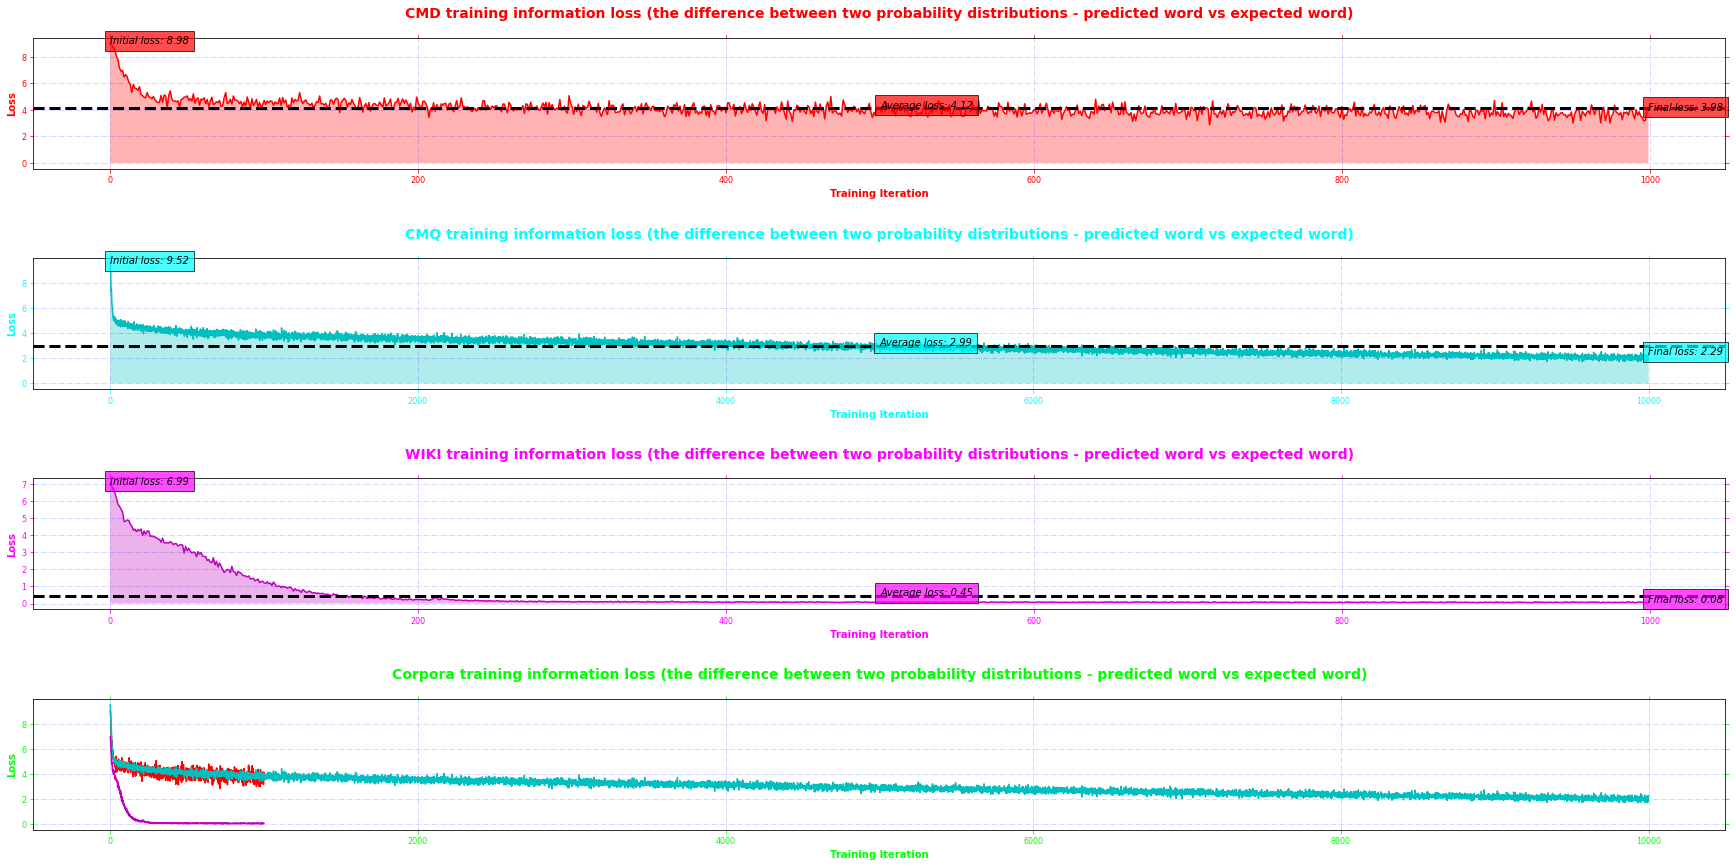

In [48]:
data_files = [] # Initialise the performance data files array
data_file_paths = {} # Initialise the performance data file paths array

read_loss_data = [] # Initialise the read data array (the loss data of corpuses already populated by previous training processes)

for i, corpus in enumerate(corpus_name): # For each corpus recognised in the corpora dictionary, do the following
    file_name = corpus + "_loss_data.txt" # Store the concatenation between the currently iterated corpus name and its trailing extension (the files name)
    data_files.append(os.path.join(corpus_data_directory, file_name)) # Configure and combine the absolute directory of the notebook and the files name
    data_file_paths[corpus] = Path(data_files[i]) # Append the path variable to the data file paths array
    read_loss_data.append('') # Initialise the current index of the read loss data array ( ['', '', ''] )
    
updateData(corpus_name, corpus_choice, data_file_paths, data_files, read_loss_data, all_losses, "train") # Function call, update the loss data for each corpus enrolled by the chatbot model

performance_data_parsed = [] # Initialise the performance data parsed array

performance_data_parsed = normaliseData(read_loss_data, "train") # Function call, normalise the loss data for each corpus enrolled by the chatbot model

subplots = [] # Initialise the subplots array, representing the loss of information during the training process of the chatbot model, for each corpus that the chatbot model supports
subplot_colours = [['r', 'red'], ['c', 'cyan'], ['m', 'magenta']] # Initialise the colour codes used to illustrate each subplot

average_losses = [] # Initialise the average losses array

for i in range(0, len(corpora), 1): # For each corpus in the chatbot models supported corpora, do the following
    subplots.append(corpora[i]) # Add a new entry to the subplot set, for the currently iterated corpus
    
    if len(performance_data_parsed[i]) == 0: # If there is no performance data populated for the corpus currently iterated, do the following
        average_losses.append(0.00) # Append an average loss of '0' to the average losses array, for the corpus currently iterated

    else: # Else if there is performance data populated for the corpus currently iterated, do the following
        average_losses.append(round(sum(performance_data_parsed[i]) / len(performance_data_parsed[i]), 2))
        
subplots.append("Corpora") # Add a new entry to the subplot set, for the corpora (comparison purposes)

figure, subplots = plt.subplots(len(corpora) + 1, sharex = False, sharey = False) # Initialise the subplots for the number of corpuses ('+1' for comparative subplot of all corpuses) supported by the chatbot model

for i in range(0, len(corpora), 1): # For each corpus in the chatbot models supported corpora, do the following
    x_coordinates = np.linspace(0, len(performance_data_parsed[i]) - 1, len(performance_data_parsed[i]))
    loss = np.array(performance_data_parsed[i]) # Create a numerical python array instance of the performance parsed array, for the currently iterated corpus
    average_loss = np.array(average_losses[i]) # Create a numerical python array instance of the average losses array, for the currently iterated corpus

    subplots[i].set_title(corpora[i] + ' training information loss (the difference between two probability distributions - predicted word vs expected word)', color = subplot_colours[i][1], fontsize = 14, fontweight = 'bold', pad = 20) # Configure the title for the subplot currently iterated
    subplots[i].set_xlabel('Training Iteration', color = subplot_colours[i][1], fontsize = 10, fontweight = 'bold') # Configure the 'X' axis label for the subplot currently iterated
    subplots[i].set_ylabel('Loss', color = subplot_colours[i][1], fontsize = 10, fontweight = 'bold') # Configure the 'Y' axis label for the subplot currently iterated
    subplots[i].tick_params(axis = 'x', labelsize = 8, colors = subplot_colours[i][1], gridOn = True, grid_alpha = 0.2, grid_linestyle = "-.", grid_color = 'b', tick1On = True, tick2On = True) # Configure the 'X' axis tick parameters for the subplot currently iterated
    subplots[i].tick_params(axis = 'y', labelsize = 8, colors = subplot_colours[i][1], gridOn = True, grid_alpha = 0.2, grid_linestyle = "-.", grid_color = 'b', tick1On = True, tick2On = True) # Configure the 'Y' axis tick parameters for the subplot currently iterated
        
    if len(performance_data_parsed[i]) != 0: # If there is performance data populated for the corpus currently iterated, do the following
        subplots[i].plot(performance_data_parsed[i], subplot_colours[i][0] + '-') # Plot the array of losses calculated and accumulated for the chatbot models training process, for the subplot currently iterated
        subplots[i].text(0, performance_data_parsed[i][0], "Initial loss: {}".format(round(performance_data_parsed[i][0], 2)), style = 'italic', 
                     bbox = {'facecolor': subplot_colours[i][1], 'edgecolor': 'black', 'alpha': 0.7, 'pad': 5}) # Configure a text label representing the intial loss of the currently iterated corpus
        subplots[i].text(len(performance_data_parsed[i]) - 1, performance_data_parsed[i][len(performance_data_parsed[i]) - 1], "Final loss: {}".format(round(performance_data_parsed[i][len(performance_data_parsed[i]) - 1], 2)), style = 'italic', 
                     bbox = {'facecolor': subplot_colours[i][1], 'edgecolor': 'black', 'alpha': 0.7, 'pad': 5}) # Configure a text label representing the final loss of the currently iterated corpus
        subplots[i].text(len(performance_data_parsed[i]) / 2, average_losses[i], "Average loss: {}".format(average_losses[i]), style = 'italic', 
                     bbox = {'facecolor': subplot_colours[i][1], 'edgecolor': 'black', 'alpha': 0.7, 'pad': 5}) # Configure a text label representing the intial loss of the currently iterated corpus
        subplots[i].axhline(y = average_losses[i], color = 'black', linewidth = 3, linestyle = "--") # Draw a line parallel to the 'X' axis, for the 'Y' axis representing the currently iterated corpuses average loss of information
        subplots[i].fill_between(x_coordinates, loss, 0, facecolor = subplot_colours[i][0], alpha = 0.3, interpolate = True) # Fill the graph space between the plot lines and the 'X' axis

subplots[len(corpora)].set_title("Corpora" + ' training information loss (the difference between two probability distributions - predicted word vs expected word)', color = 'lime', fontsize = 14, fontweight = 'bold', pad = 20) # Configure the title for the corpora subplot
subplots[len(corpora)].set_xlabel('Training Iteration', color = 'lime', fontsize = 10, fontweight = 'bold') # Configure the 'X' axis label for the corpora subplot
subplots[len(corpora)].set_ylabel('Loss', color = 'lime', fontsize = 10, fontweight = 'bold') # Configure the 'Y' axis label for the corpora
subplots[len(corpora)].tick_params(axis = 'x', labelsize = 8, colors = 'lime', gridOn = True, grid_alpha = 0.2, grid_linestyle = "-.", grid_color = 'b', tick1On = True, tick2On = True) # Configure the 'X' axis tick parameters for the corpora subplot
subplots[len(corpora)].tick_params(axis = 'y', labelsize = 8, colors = 'lime', gridOn = True, grid_alpha = 0.2, grid_linestyle = "-.", grid_color = 'b', tick1On = True, tick2On = True) # Configure the 'Y' axis tick parameters for the corpora subplot

for i in range(0, len(corpora) + 1, 1): # For each corpus in the chatbot models supported corpora ('+1' for averaged subplot), do the following
    if i != len(corpora): # If the currently iterated corpus is not the last corpus in the corpora, do the following
        subplots[len(corpora)].plot(performance_data_parsed[i], subplot_colours[i][0] + '-') # Plot the array of losses calculated and accumulated for the chatbot models training process, for the corpora subplot
    else: # Else if the currently iterated corpus is the last corpus in the corpora, do the following
        same_length = 1 # Initialise the count of the number of corpuses that were trained for the same number of iterations
        length = 0 # Initialise the number of training iterations performed for the first corpus iterated in the corpora

        for j in range(0, len(corpora), 1): # For each corpus in the chatbot models supported corpora, do the following
            if j == 0: # If the currently iterated corpus is the first corpus in the corpora, do the following
                length = len(performance_data_parsed[j]) # Set the number of training iterations performed for the first corpus iterated in the corpora, to the number of indexes that the performance data parsed array contains for it
            else: # Else if the currently iterated corpus is not the first corpus in the corpora, do the following
                if len(performance_data_parsed[j]) == length: # If the currenlty itearted corpus was trained for the same number of iterations as the first corpus in the corpora, do the following
                    same_length += 1 # Increment the number of corpuses containing performance data for the same number of training iterations
        
        averaged_performance_data = [] # Initialise the averaged performance data array

        if same_length == len(performance_data_parsed): # If all corpuses were trained for the same number of iterations, do the following
            for k in range(0, len(corpora), 1): # For each corpus in the corpora array, do the following
                for l in range(0, length, 1): # For the number of training iterations performed for each corpus in the corpora, do the following
                    if len(averaged_performance_data) != length: # If the average performance data array has not been populated to the number of training iterations performed by each corpus in the corpora, do the following
                        averaged_performance_data.append(performance_data_parsed[k][l]) # Append the performance data for the currently iterated corpus, for the currently iterated training iteration, to the averaged performance data array
                    
                    else: # Else if the average performance data array has been populated to the number of training iterations performed by each corpus in the corpora, do the following
                        averaged_performance_data[l] = averaged_performance_data[l] + performance_data_parsed[k][l] # Add the performance data for the currently iterated corpus, for the currently iterated training iteration, to the averaged performance data array (accumulate corpus performance data)

            for m in range(0, length, 1): # For the number of training iterations performed for each corpus in the corpora, do the following 
                averaged_performance_data[m] = averaged_performance_data[m] / len(corpora) # Store the averaged performance data, for the accumulated performance data of each corpus in the corpora, for every training iteration performed

            average_losses.append(round((sum(averaged_performance_data) / len(averaged_performance_data)), 2)) # Append the average loss for the averaged performance data, compiled for the currently iterated corpus

            subplots[len(corpora)].plot(averaged_performance_data, 'g-') # Plot the array of losses calculated and accumulated for the chatbot models training process, for the corpora subplot (average for all corpuses)
            subplots[len(corpora)].text(0, averaged_performance_data[0], "Initial loss (average): {}".format(round(averaged_performance_data[0], 2)), style = 'italic', 
                     bbox = {'facecolor': 'lime', 'edgecolor': 'black', 'alpha': 0.7, 'pad': 5}) # Configure a text label representing the intial loss of the currently iterated corpus
            subplots[len(corpora)].text(len(averaged_performance_data) - 1, averaged_performance_data[len(averaged_performance_data) - 1], "Final loss (average): {}".format(round(averaged_performance_data[len(averaged_performance_data) - 1], 2)), style = 'italic', 
                     bbox = {'facecolor': 'lime', 'edgecolor': 'black', 'alpha': 0.7, 'pad': 5}) # Configure a text label representing the final loss of the currently iterated corpus
            subplots[i].text(len(averaged_performance_data) / 2, sum(averaged_performance_data) / len(averaged_performance_data), "Average loss (average): {}".format(average_losses[len(average_losses) - 1]), style = 'italic', 
                     bbox = {'facecolor': 'lime', 'edgecolor': 'black', 'alpha': 0.7, 'pad': 5}) # Configure a text label representing the intial loss of the currently iterated corpus
            subplots[i].axhline(y = average_losses[len(average_losses) - 1], color = 'black', linewidth = 3, linestyle = "--") # Draw a line parallel to the 'X' axis, for the 'Y' axis representing the currently iterated corpuses average loss of information

figure.set_figheight(10) # Set the height of the figure in each subplot instance
figure.set_figwidth(10) # Set the width of the figure in each subplot instance
figure.tight_layout() # Set the format of the subplot layout to be tightly arranged
figure.subplots_adjust(left = 0, bottom = 0, right = 2.35, top = 1.1, wspace = None, hspace = None) # Set the alignment of the subplots

### **Training Loss Data Summary Table**
---------

Present the training loss data compiled for each of the corpuses supported by the chatbot model, in a summary table

In [49]:
summary_table_corpus = [] # Initialise the summary table corpus array (store corpus names)
summary_table_fields = ['Corpus', 'Initial Loss', 'Final Loss', 'Loss Range', 'Average Loss'] # Initialise the summary table fields array (store table headers)
summary_table_values = [] # Initialise the summary table value array (store the values for the corresponding table header fields)

corpus_names = [] # Initialise the corpus names array
intial_losses = [] # Initialise the initial losses array
final_losses = [] # Initialise the final losses array
loss_ranges = [] # Initialise the loss ranges array
losses_average = [] # Initialise the losses average array

for i in range(0, len(corpora), 1): # For each corpus in the chatbot models supported corpora, do the following
    if len(performance_data_parsed[i]) != 0: # If there is performance data populated for the corpus currently iterated, do the following
        initial_loss = performance_data_parsed[i][0] # Store the initial loss calculated at the start of the training process for the chatbot model
        final_loss = performance_data_parsed[i][len(performance_data_parsed[i]) - 1] # Store the final calculated loss of the training process for the chatbot model
    
    else: # Else if there is no performance data populated for the corpus currently iterated, do the following
        initial_loss = 0.00 # Set the initial loss calculated at the start of the training process for the chatbot model to '0'
        final_loss = 0.00 # Set the final loss calculated at the start of the training process for the chatbot model to '0'

    corpus_names.append(corpora[i]) # Append the name of the currently iterated corpus to the corpus names array
    intial_losses.append(str(round(initial_loss, 2))) # Append the initial loss of information for the currently iterated corpus, to the initial losses array
    final_losses.append(str(round(final_loss, 2))) # Append the final loss of information for the currently iterated corpus, to the final losses array
    loss_ranges.append(str(abs(round(initial_loss - final_loss, 2)))) # Append the range of information loss for the currently iterated corpus, to the loss ranges array
    losses_average.append(str(round(average_losses[i], 2))) # Append the average loss of informtaion for the currently iterated corpus, to the losses average array

summary_table_values = [corpus_names, intial_losses, final_losses, loss_ranges, losses_average] # Store each array as a seperate field in the summary table values array (columnised)

summary_table = go.Figure(data = [go.Table(
     header = dict(values = summary_table_fields,
               line_color = 'black',
               fill_color = 'black',
                    align = 'center',
        font = dict(color = 'white', size = 12)),
      cells = dict(values = summary_table_values,
               line_color = 'black',
               fill_color = [['lightgrey', 'white'] * len(corpora)],
                    align = 'center',
        font = dict(color = 'black', size = 12)))
]) # Create a summary table object instance, passing the performance data compiled and calculated for each corpus supported by the chatbot model

summary_table.update_layout(width = None, height = None) # Update the layout of the summary table instance
summary_table.show() # Generate and display the summary table object instance (after updating its layout) 

### **Model Evaluation Accuracy**
---------

Evaluate the accuracy of the current chatbot model configuration, using a series of sequence matching techniques to accumulate individual scores

In [50]:
# Function declaration, concatenate split apostrophised words
def concatenateApostrophisedWords(query_sentence, target_response_sentence, response_sentence):
    split_sentence = [] # Initialise the split sentence array
    sorted_sentence = [] # Initialise the sorted sentence array
        
    apostrophe_characters = ["re", "t", "ve", "m", "d", "ll", "s"] # Initialise the apostrophe characters array
    sentences = [query_sentence, target_response_sentence, response_sentence] # Initialise the sentences array
        
    # Concatenate the split apostrophised words
    for j in range(0, 3, 1): # For each type of sentence in the sentence array, do the following
        split_sentence = sentences[j].split() # Split each word in the currently iterated sentence into seperate elements in the list
            
        for k in range(0, len(split_sentence), 1): # For each word in the currently split sentence, do the following
            if len(split_sentence[k]) <= 2: # If the currently iterated word in the currently split sentence is smaller than or equal to '2' characters in length, do the following
                if split_sentence[k] in apostrophe_characters: # If the currently iterated word is an apostrophe character, do the following
                    if k > 0 and len(split_sentence[k]) >= 1: # If the current iteration is not first iteration and the currently iterated words length is larger than or equal to '1' character, do the following
                        sorted_sentence[k - 1] = '' # Reinitialise the previously iterated index of the sorted sentence array (prepare for new input)
                        sorted_sentence.insert(k - 1, split_sentence[k - 1] + split_sentence[k]) # Store the apostrophised word at the previously iterated index (dont, t = dont, '')
                        
                    else: # Else if the current iteration is the first iteration or the currently iterated words length is smaller than '1' character, do the following
                        sorted_sentence.append(split_sentence[k]) # Append the currently iterated word in the currently split sentence to the sorted sentence array
                
                else: # Else if the currently iterated word is not an apostrophe character, do the following
                    sorted_sentence.append(split_sentence[k]) # Append the currently iterated word in the currently split sentence to the sorted sentence array
              
            elif len(split_sentence[k]) > 2: # Else if the currently iterated word in the currently split sentence is larger than '2' characters in length, do the following
                sorted_sentence.append(split_sentence[k]) # Append the currently iterated word in the currently split sentence to the sorted sentence array
              
        if j == 0: # If the query sentence is currently being sorted, do the following
            sentences[j] = sorted_sentence # Set the query sentence to the current iteration of the sorted sentence array
            sorted_sentence = [] # Reinitialise the sorted sentence array (for future iterations)
        
        elif j == 1: # Else if the target response sentence is currently being sorted, do the following
            sentences[j] = sorted_sentence # Set the target response sentence to the current iteration of the sorted sentence array
            sorted_sentence = [] # Reinitialise the sorted sentence array (for future iterations)

        elif j == 2: # Else if the response sentence is currently being sorted, do the following
            sentences[j] = sorted_sentence # Set the response sentence to the current iteration of the sorted sentence array
            sorted_sentence = [] # Reinitialise the sorted sentence array (for future iterations)

    query_sentence = ' '.join(sentences[0]) # Concatenate the elements of the query sentence index, in the sentence array, to a string
    target_response_sentence = ' '.join(sentences[1]) # Concatenate the elements of the target response sentence index, in the sentence array, to a string
    response_sentence = ' '.join(sentences[2]) # Concatenate the elements of the response sentence index, in the sentence array, to a string

    query_sentence = re.sub(r"\s+", r" ", query_sentence).strip() # Replace multiple white space characters for a single white space character
    target_response_sentence = re.sub(r"\s+", r" ", target_response_sentence).strip() # Replace multiple white space characters for a single white space character
    response_sentence = re.sub(r"\s+", r" ", response_sentence).strip() # Replace multiple white space characters for a single white space character

    return query_sentence, target_response_sentence, response_sentence # Return the query, target response and reponse sentences

In [51]:
# Function declaration, calculate the cosine similarity between the target and generated response sentences
def cosineSimilarity(target_response_sentence, response_sentence):
    cosine = 0 # Initialise the cosine ratio
    cosine_similarity = 0 # Initialise the cosine similarity
    
    target_response_sentence = target_response_sentence.lower() # Reformat the target response sentence to be in the lower case format (if capital)
    response_sentence = response_sentence.lower() # Reformat the response sentence to be in the lower case format (if capital)
   
    target_response_sentence = word_tokenize(target_response_sentence) # Store the target response sentence, tokenized  
    response_sentence = word_tokenize(response_sentence) # Store the response sentence, tokenized
  
    stop_words = stopwords.words('english') # Store the sentence stop words for the English language

    word_in_target = [] # Initialise the word in target array
    word_in_response = [] # Initiailise the word in response array
  
    target_response_trimmed = {word for word in target_response_sentence if not word in stop_words} # Store the target response sentence, filtered from the stop words of the language passed
    response_trimmed = {word for word in response_sentence if not word in stop_words} # Store the response sentence, filtered from the stop words of the language passed

    all_words = target_response_trimmed.union(response_trimmed) # Store the set of words that exist in the target response and reponse sentences (duplicates excluded) 
    
    for word in all_words: # For each word in all the words existing in the target response and reponse sentences (excluding stop words), do the following
        if word in target_response_trimmed: # If the currently iterated word exists in the target response sentence, do the following
            word_in_target.append(1) # Append '1' to the word in target array, representing that the currently iterated word exists in the sentence
        
        else: # Else if the currently iterated word does not exist in the target response sentence, do the following
            word_in_target.append(0) # Append '0' to the word in target array, representing that the currently iterated word does not exist in the sentence
        
        
        if word in response_trimmed: # If the currently iterated word exists in the response sentence, do the following
            word_in_response.append(1) # Append '1' to the word in response array, representing that the currently iterated word exists in the sentence
        
        else: # Else if the currently iterated word does not exist in the response sentence, do the following
            word_in_response.append(0) # Append '0' to the word in response array, representing that the currently iterated word does not exist in the sentence
  
    # Cosine function  
    for i in range(len(all_words)): # For the number of words existing in the target response and response sentences (excluding stop words), do the following
        cosine += word_in_target[i] * word_in_response[i] # Set the cosine ratio to accumulate the values in the word in target and response arrays, for the currently iterated word (ratio of word containing in both)
    
    if sum(word_in_target) > 0 and sum(word_in_response) > 0: # If the target response and response sentences share at least one word (irrespective of order), do the following
        cosine_similarity = cosine / float((sum(word_in_target) * sum(word_in_response)) ** 0.5) # Calculate the cosine similarity of the sentences (words in the sentences)
    
    return cosine_similarity # Return the calculated cosine similarity

In [52]:
# Function declaration, calculate the response accuracy for the chatbot model configuration compiled
def ResponseAccuracy(vocabulary, sentence_pairs, encoder, decoder, searcher, number_of_iterations):
    model_accuracy_sentences = [] # Initialise the model accuracy sentences array (accuracy of total sentence predictions)
    model_accuracy_words = [] # Initialise the model accuracy words array (accuracy of total word predictions)
    bleu_score_total = [] # Initialise the total BLEU score array (accuracy of words predicted for all sentences)
    bleu_score = 0 # Initialise the BLEU score for the response sentence being evaluated (accuracy of words predicted for the current sentence) 
    levenshtein_accuracy_total = [] # Initialise the total Levenshtein accuracy 
    sequence_matcher_accuracy_total = [] # Initialise the total sequence matcher accuracy
    cosine_accuracy_total = [] # Initialise the total cosine accuracy
     
    words_correct_total = 0 # Initialise the total correctly predicted word count
    words_evaluated_total = 0 # Initialise the total number of words evaluated
    words_correct = 0 # Initialise the correctly predicted word count
    words_evaluated = 0 # Initialise the number of words evaluated

    if number_of_iterations > len(sentence_pairs): # If the number of evaluation iterations is larger than the number of sentence pairs populated for the chatbot model, do the following
        print("The number of evaluation iterations [{}] exceeds the number of sentence pairs [{}] populated!".format(number_of_iterations, len(sentence_pairs))) # Output that the number of evaluation iterations exceeds the number of sentence pairs populated for the chatbot model
        number_of_iterations = len(sentence_pairs) # Set the number of evaluation iterations to the length of the sentence pairs array
        print("Now evaluating all [{}] sentence pairs...\n".format(number_of_iterations)) # Output the updated number of iterations to be executed for evaluating the chatbot models configuration

    for i in range(0, number_of_iterations, 1): # For the number of iterations configured for the chatbot models response accuracy to be measured within, do the following
        query_sentence = sentence_pairs[i][0] # Store the query sentence of the currently iterated sentence pairs, populated for training the chatbot model configured
        target_response_sentence = sentence_pairs[i][1] # Store the response sentence of the currently iterated sentence pairs, populated for training the chatbot model configured

        query_sentence = normalizeString(query_sentence) # Normalise the query sentence (Unicode to ASCII encoding for the chatbot model to handle)

        response_sentence = evaluate(encoder, decoder, searcher, vocabulary, query_sentence) # Evaluate the query sentence, to produce a response sentence that has been approproated to it 
        response_sentence[:] = [word_token for word_token in response_sentence if not (word_token == 'EOS' or word_token == 'PAD')] # Compile the sequence of words in the order compiled, discarding the end-of-sentence and padding (zeros) tokens 
        response_sentence = ' '.join(response_sentence) # Concatenate the elements of the response sentence array, to a string

        characters_to_replace = "[^0-9a-zA-Z]+" # Initialise the characters to replace string (everything non-alphanumeric)
                    
        query_sentence = re.sub(characters_to_replace, " ", query_sentence) # Replace all non-alphanumeric characters in the query sentence, to a whitespace character
        target_response_sentence = re.sub(characters_to_replace, " ", target_response_sentence) # Replace all non-alphanumeric characters in the target response sentence, to a whitespace character
        response_sentence = re.sub(characters_to_replace, " ", response_sentence) # Replace all non-alphanumeric characters in the response sentence, to a whitespace character
            
        query_sentence, target_response_sentence, response_sentence = concatenateApostrophisedWords(query_sentence, target_response_sentence, response_sentence) # Function call, concatenate split apostrophised words for all sentences passed
        
        #print("[Query: {}]  [Target response: {}]  [Response: {}]".format(query_sentence, target_response_sentence, response_sentence)) # Ouput the query, target response and response sentences for the chatbot model 



        # Calculate the percentage of misclassification (zero-one loss) of the chatbot model configuration compiled
        # Inspired by the concept delivered in: https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model 
        split_sentence = [] # Reinitialise the split sentence array
        sentences = [query_sentence, target_response_sentence, response_sentence] # Reinitialise the sentences array

        for j in range(0, 3, 1): # For each type of sentence in the sentence array, do the following
            split_sentence.append(sentences[j].split()) # Append the currently split iterated sentence to the split sentence array

        for j in range(0, len(split_sentence[2]), 1): # For the length of the response sentence compiled by the chatbot model configuration, do the following
            if j < len(split_sentence[1]): # If the currently iterated word is not the last word in the target response sentence, do the following
                if split_sentence[1][j] == split_sentence[2][j]: # If the currently iterated word exists at the same index in both sentences, do the following
                    words_correct += 1 # Increment the number of words predicted correctly
                    words_evaluated += 1 # Increment the total number of words evaluated
            
                else: # Else if the currently iterated word does not exist at the same index in both sentences, do the following
                    words_evaluated += 1 # Increment the total number of words evaluated
            
            else: # Else if the currently iterated word is the last, or is beyond the last word in the target response sentence, do the following
                words_evaluated += 1 # Increment the total number of words evaluated

        if words_correct > 0: # If at least one word was correctly predicted in the target sentence by the chatbot model configuration, do the following 
            model_accuracy_sentences.append(words_correct / words_evaluated) # Append the ratio of the number of words predicted correctly, relative to the size of the response that the chatbot model produced, to the model accuracy sentence array

        else: # Else if no word was correctly predicted in the target sentence by the chatbot model configuration, do the following 
            model_accuracy_sentences.append(0) # Append '0' to the model accuracy sentence array (incorrect sentence) 



        # Calculate the percentage of misclassification of the chatbot model configuration compiled, using BLEU scoring (Bilingual Evaluation Understudy)
        # Discovered at: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
        reference = target_response_sentence.split() # Set the reference sentence (comparing sentence) to the target response sentence (n-gram - word for word scoring)
        candidate = response_sentence.split() # Set the candidate sentence (generated sentence) to the response sentence (n-gram - word for word scoring)
        smooth = SmoothingFunction().method0 # Define the smoothing method for BLEU scoring calculation
        
        if target_response_sentence is not "": # If the target sentence in the sentence pair currently iterated, is not an empty character, do the following
            bleu_score = sentence_bleu(reference, candidate, smoothing_function = smooth, auto_reweigh = False, emulate_multibleu = False) # Calculate the BLEU score of the currently iterated sentence pair

            if model_accuracy_sentences[i] > bleu_score: # If the sentence accuracy calculated by the order of the words in the currently iterated response and target response sentence pairs (zero-one loss method), is larger than its BLEU score (prevent word for word accurate sentences receiving less than '1.0' score - BLEU inaccurate), do the following 
                bleu_score = model_accuracy_sentences[i] # Update the BLEU score to the score computed by the zero-one loss method (words correct vs words evaluated)
        else: # Else if the target sentence in the sentence pair currently iterated, is an empty character, do the following
            bleu_score = 0 # Set the BLEU score to '0' (no match)

        bleu_score_total.append(bleu_score) # Append the BLEU score for the currently iterated sentence pair (all sentence scores combined), to the BLEU score total array
        
        #print("[Target response: {}]  [Response: {}]  [BLEU score (total): {}%]  [BLEU score (sentence): {}%]  [Sentence accuracy: {}%]"
              #.format(reference, candidate, round(sum(bleu_score_total), 2), round(bleu_score, 2), round(model_accuracy_sentences[i], 2))) # Output the BLEU score accuracies of the chatbot models configuration



        # Calculate the percentage of misclassification of the chatbot model configuration compiled, using Levenshtein distance (the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other)
        # Discovered at: https://stackoverflow.com/questions/6690739/high-performance-fuzzy-string-comparison-in-python-use-levenshtein-or-difflib
        levenshtein_accuracy_total.append(Levenshtein.ratio(target_response_sentence, response_sentence)) # Append the Levenshtein similarity calculated for the currently iterated sentence pair, to the Levenshtein accuracy total array 
        
        
        
        # Calculate the percentage of misclassification of the chatbot model configuration compiled, using sequence matching (applies Ratcliff and Obershelp's “gestalt pattern matching” algorithm)
        # Discovered at: https://stackoverflow.com/questions/6690739/high-performance-fuzzy-string-comparison-in-python-use-levenshtein-or-difflib
        sequence_matcher_accuracy_total.append(SequenceMatcher(None, target_response_sentence, response_sentence).ratio()) # Append the sequence matcher accuracy calculated for the currently iterated sentence pair, to the sequence matcher accuracy total array 
        
        

        # Calculate the percentage of misclassification of the chatbot model configuration compiled, using cosine similarity (cosine of the angle between two vectors projected in a multi-dimensional space (irrespective of different vector sizes); smaller the angle, higher the degree of similarity)
        # Discovered at: https://www.geeksforgeeks.org/python-measure-similarity-between-two-sentences-using-cosine-similarity/
        cosine_accuracy_total.append(cosineSimilarity(target_response_sentence, response_sentence))



        #print("[Target response: {}]  [Response: {}]  [Words correct total: {}]  [Words incorrect total: {}]  [Words correct sentence: {}]  [Words in sentence accuracy: {}%]  [BLEU score: {}%]"
              #.format(target_response_sentence, response_sentence, words_correct_total, words_evaluated_total - words_correct_total, words_correct, 
              #round((words_correct / words_evaluated) * 100, 2), round(bleu_score, 2))) # Output the word and sentence accuracies of the chatbot models configuration

        words_correct_total += words_correct # Accumulate the correctly predicted word count
        words_evaluated_total += words_evaluated # Accumulate the evaluated word count

        words_correct = 0 # Reinitialise the correctly predicted word count (for future iterations)
        words_evaluated = 0 # Reinitialise the evaluated word count (for future iterations)

    model_accuracy_words = round((words_correct_total / words_evaluated_total) * 100, 2) # Calculate the accuracy of the words predicted (predicted vs actual) by the chatbot models configuration
    
    return number_of_iterations, words_correct_total, words_evaluated_total - words_correct_total, words_evaluated_total, model_accuracy_words, bleu_score_total, levenshtein_accuracy_total, sequence_matcher_accuracy_total, cosine_accuracy_total # Return the correct and incorrect words counts predicted by the chatbot model and the word and sentence accuracies calculated

In [53]:
# Set the dropout layers to evaluation mode
encoder.eval() # Function call, evaluate the encoder model (RNN)
decoder.eval() # Function call, evaluate the decoder model (RNN)

searcher = GreedySearchDecoder(encoder, decoder) # Initialise the search module using the greedy decoder (decoding method of the chatbot model)

number_of_evaluation_iterations = 1000 # Initialise the number of evaluation iterations that are going to be performed on the chatbot models current configuration

number_of_evaluation_iterations, words_correct, words_incorrect, words_evaluated, model_accuracy, bleu_accuracy, levenshtein_accuracy, sequence_matcher_accuracy, cosine_accuracy_total = ResponseAccuracy(vocabulary, evaluation_pairs, encoder, decoder, searcher, number_of_evaluation_iterations) # Return the accuracy related variables of the chatbot model configuration

average_cosine_similarity_accuracy = round((sum(cosine_accuracy_total) / len(cosine_accuracy_total)) * 100, 2) # Calculate the cosine similarity accuracy
average_sequence_matcher_accuracy = round((sum(sequence_matcher_accuracy) / len(sequence_matcher_accuracy)) * 100, 2) # Calculate the sequence matcher accuracy
average_levenshtein_accuracy = round((sum(levenshtein_accuracy) / len(levenshtein_accuracy)) * 100, 2) # Calculate the averaged Levenshtein similarity
average_bleu_score_accuracy = round((sum(bleu_accuracy) / len(bleu_accuracy)) * 100, 2) # Calculate the averaged BLEU score accuracy

print("\n[Levenshtein accuracy: {}%]\n[BLEU score accuracy: {}%]\n[Sequence matcher accuracy: {}%]\n[Cosine similarity accuracy: {}%]\n[Ordered token-by-token accuracy: {}%]  [Sentences: {}/{}]  [Words: {}/{}/{}]\n" 
      .format(average_levenshtein_accuracy, average_bleu_score_accuracy, average_sequence_matcher_accuracy, average_cosine_similarity_accuracy, model_accuracy, 
              bleu_accuracy.count(1), number_of_evaluation_iterations, words_correct, words_incorrect, words_correct + words_incorrect)) # Output the accuracy of the chatbot model, for the configuration compiled

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning:


Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().




[Levenshtein accuracy: 28.46%]
[BLEU score accuracy: 15.98%]
[Sequence matcher accuracy: 25.55%]
[Cosine similarity accuracy: 3.8%]
[Ordered token-by-token accuracy: 3.6%]  [Sentences: 37/1000]  [Words: 108/2890/2998]



### **Model Evaluation Accuracy Summary Table**
---------

Present the series of evaluation accuracy data compiled for each of the corpuses supported by the chatbot model, in a summary table

In [54]:
data_file = '' # Initialise the performance data files array
data_file_path = '' # Initialise the performance data file paths array

read_accuracy_data = [] # Initialise the read data array (the accuracy data of corpuses already populated by previous evaluation processes)

file_name = "corpora_accuracy_data.txt" # Define the name of the corpora accuracy data
data_file = os.path.join(corpus_data_directory, file_name) # Configure and combine the absolute directory of the notebook and the files name
data_file_path = Path(data_file) # Append the path variable to the data file paths array

for i, corpus in enumerate(corpus_name): # For each corpus recognised in the corpora dictionary, do the following
    read_accuracy_data.append(corpus) # Initialise the current index of the read accuracy data array ( ['', '', ''] )

# Corpus name, ordered token-by-token accuracy, correct words, inccorect words, evaluated words, BLEU score accuracy, Levenshtein accuracy, sequence matcher accuracy, cosine similarity accuracy, number of training iterations, number of evaluation iterations
accuracy_data = [corpus_choice,
                 str(model_accuracy), str(words_correct), str(words_incorrect), str(words_correct + words_incorrect), 
                 str(average_bleu_score_accuracy), 
                 str(average_levenshtein_accuracy), 
                 str(average_sequence_matcher_accuracy),
                 str(average_cosine_similarity_accuracy),
                 str(number_of_training_iterations),  
                 str(number_of_evaluation_iterations)] # Initialise the accuracy data array

updateData(corpus_name, corpus_choice, data_file_path, data_file, read_accuracy_data, accuracy_data, "evaluate") # Function call, update the accuracy data for each corpus enrolled by the chatbot model

accuracy_data_parsed = [] # Initialise the accuracy data parsed array

accuracy_data_parsed = normaliseData(read_accuracy_data, "evaluate") # Function call, normalise the accuracy data for each corpus enrolled by the chatbot model

summary_table_fields = ['Corpus', 'Token-by-token Accuracy', 'BLEU Score Accuracy', 'Levenshtein Accuarcy', 'Sequence Matcher Accuracy', 'Cosine Similarity Accuracy', 'Cumulative Accuracy', 'Training Iterations', 'Evaluation Iterations'] # Initialise the summary table fields array (store table headers)
summary_table_values = [] # Initialise the summary table value array (store the values for the corresponding table header fields)

model_accuracies = [] # Initialise the model accuracies array
bleau_accuracies = [] # Initialise the BLEU score accuracies array
levenshtein_accuracies = [] # Initialise the Levenshtein accuracies array
sequence_matcher_accuracies = [] # Initialise the sequence matcher accuracies array
cosine_similarity_accuracies = [] # Initialise the cosine similarity accuracies array
training_iterations = [] # Initialise the training iterations array
evaluation_iterations = [] # Initialise the evaluation iterations array
cumulative_accuracies = [] # Initialise the cumulative accuracies array

for i in range(0, len(corpora), 1): # For each corpus in the chatbot models supported corpora, do the following
    table_values = {"accuracy model": '', "correct words": '', "incorrect words": '', "evaluated words": '', "accuracy bleu": '', 
                    "accuracy levenshtein": '', "accuracy sequence matcher": '', "accuracy cosine similarity": '', "iterations training": '', "iterations evaluation": ''} # Initialise the table values dictionary

    table_value_keys = list(table_values.keys()) # Store the keys of the table value keys dictionary

    for j in range(0, len(accuracy_data_parsed[i]), 1): # For each data field in the accuracy data parsed array, do the following
        table_values[table_value_keys[j]] = accuracy_data_parsed[i][j] # Store the currently iterated data in the accuracy parsed data array, in the corresponding data field within the table values dictionary

    model_accuracies.append("{}% [{}/{}/{}]".format(table_values["accuracy model"], table_values["correct words"], table_values["incorrect words"], table_values["evaluated words"])) # Append the ordered token-by-token accuracy for the currently iterated corpus, to the model accuracies array
    bleau_accuracies.append("{}%".format(table_values["accuracy bleu"])) # Append the BLEU accuracy for the currently iterated corpus, to the BLEU accuracies array
    levenshtein_accuracies.append("{}%".format(table_values["accuracy levenshtein"])) # Append the Levenshtein accuracy for the currently iterated corpus, to the Levenshtein accuracies array
    sequence_matcher_accuracies.append("{}%".format(table_values["accuracy sequence matcher"])) # Append the sequence matcher accuracy for the currently iterated corpus, to the sequence matcher accuracies array
    cosine_similarity_accuracies.append("{}%".format(table_values["accuracy cosine similarity"])) # Append the cosine similarity accuracy for the currently iterated corpus, to the cosine similarity accuracies array
    cumulative_accuracies.append("{}%".format(round((table_values["accuracy model"] + table_values["accuracy bleu"] + table_values["accuracy levenshtein"] + table_values["accuracy sequence matcher"] + table_values["accuracy cosine similarity"]) / 5, 2))) # Append the cumulative accuracy for the currently iterated corpus, to the cumulative accuracies array
    training_iterations.append("{}".format(table_values["iterations training"])) # Append the number of training iterations for the currently iterated corpus, to the training iterations array
    evaluation_iterations.append("{}".format(table_values["iterations evaluation"])) # Append the number of evaluation iterations for the currently iterated corpus, to the evaluation iterations array

summary_table_values = [corpus_names, model_accuracies, bleau_accuracies, levenshtein_accuracies, sequence_matcher_accuracies, cosine_similarity_accuracies, cumulative_accuracies, training_iterations, evaluation_iterations] # Store each array as a seperate field in the summary table values array (columnised)

summary_table = go.Figure(data = [go.Table(
     header = dict(values = summary_table_fields,
               line_color = 'black',
               fill_color = 'black',
                    align = 'center',
        font = dict(color = 'white', size = 12)),
      cells = dict(values = summary_table_values,
               line_color = 'black',
               fill_color = [['lightgrey', 'white'] * len(corpora)],
                    align = 'center',
        font = dict(color = 'black', size = 12)))
]) # Create a summary table object instance, passing the evaluation data compiled and calculated for each corpus supported by the chatbot model

summary_table.update_layout(width = None, height = None) # Update the layout of the summary table instance
summary_table.show() # Generate and display the summary table object instance (after updating its layout) 

## **Run Evaluation**
---------



Intervene with the chatbot model (conversate)

In [ ]:
scripted_input = False # Determine whether the chatbot model is to evaulate live input or a series of scripted input

# Set the dropout layers to evaluation mode
#encoder.eval() # Function call, evaluate the encoder model (RNN)
#decoder.eval() # Function call, evaluate the decoder model (RNN)

# Initialise the search module using the greedy decoder (decoding method of the chatbot model)
#searcher = GreedySearchDecoder(encoder, decoder)

# Initiate the chatbot (live conversation)
evaluateInput(encoder, decoder, searcher, vocabulary, scripted_input)